--- Starting GBLUP Benchmark ---

--- Generation 1/20 ---
  -> Total Population Size: 50
  -> Latest Gen Size: 50
  -> Prediction Time: 0.9695s
  -> Prediction Accuracy (Latest Gen): 0.7706
  -> Genetic Variance (Latest Gen):    1.0000

--- Generation 2/20 ---
  -> Total Population Size: 200
  -> Latest Gen Size: 200
  -> Prediction Time: 0.3384s
  -> Prediction Accuracy (Latest Gen): 0.7665
  -> Genetic Variance (Latest Gen):    1.2932

--- Generation 3/20 ---
  -> Total Population Size: 200
  -> Latest Gen Size: 200
  -> Prediction Time: 0.0130s
  -> Prediction Accuracy (Latest Gen): 0.7572
  -> Genetic Variance (Latest Gen):    1.0416

--- Generation 4/20 ---
  -> Total Population Size: 200
  -> Latest Gen Size: 200
  -> Prediction Time: 0.0078s
  -> Prediction Accuracy (Latest Gen): 0.7297
  -> Genetic Variance (Latest Gen):    0.9012

--- Generation 5/20 ---
  -> Total Population Size: 200
  -> Latest Gen Size: 200
  -> Prediction Time: 0.0189s
  -> Prediction Accuracy (Latest Gen

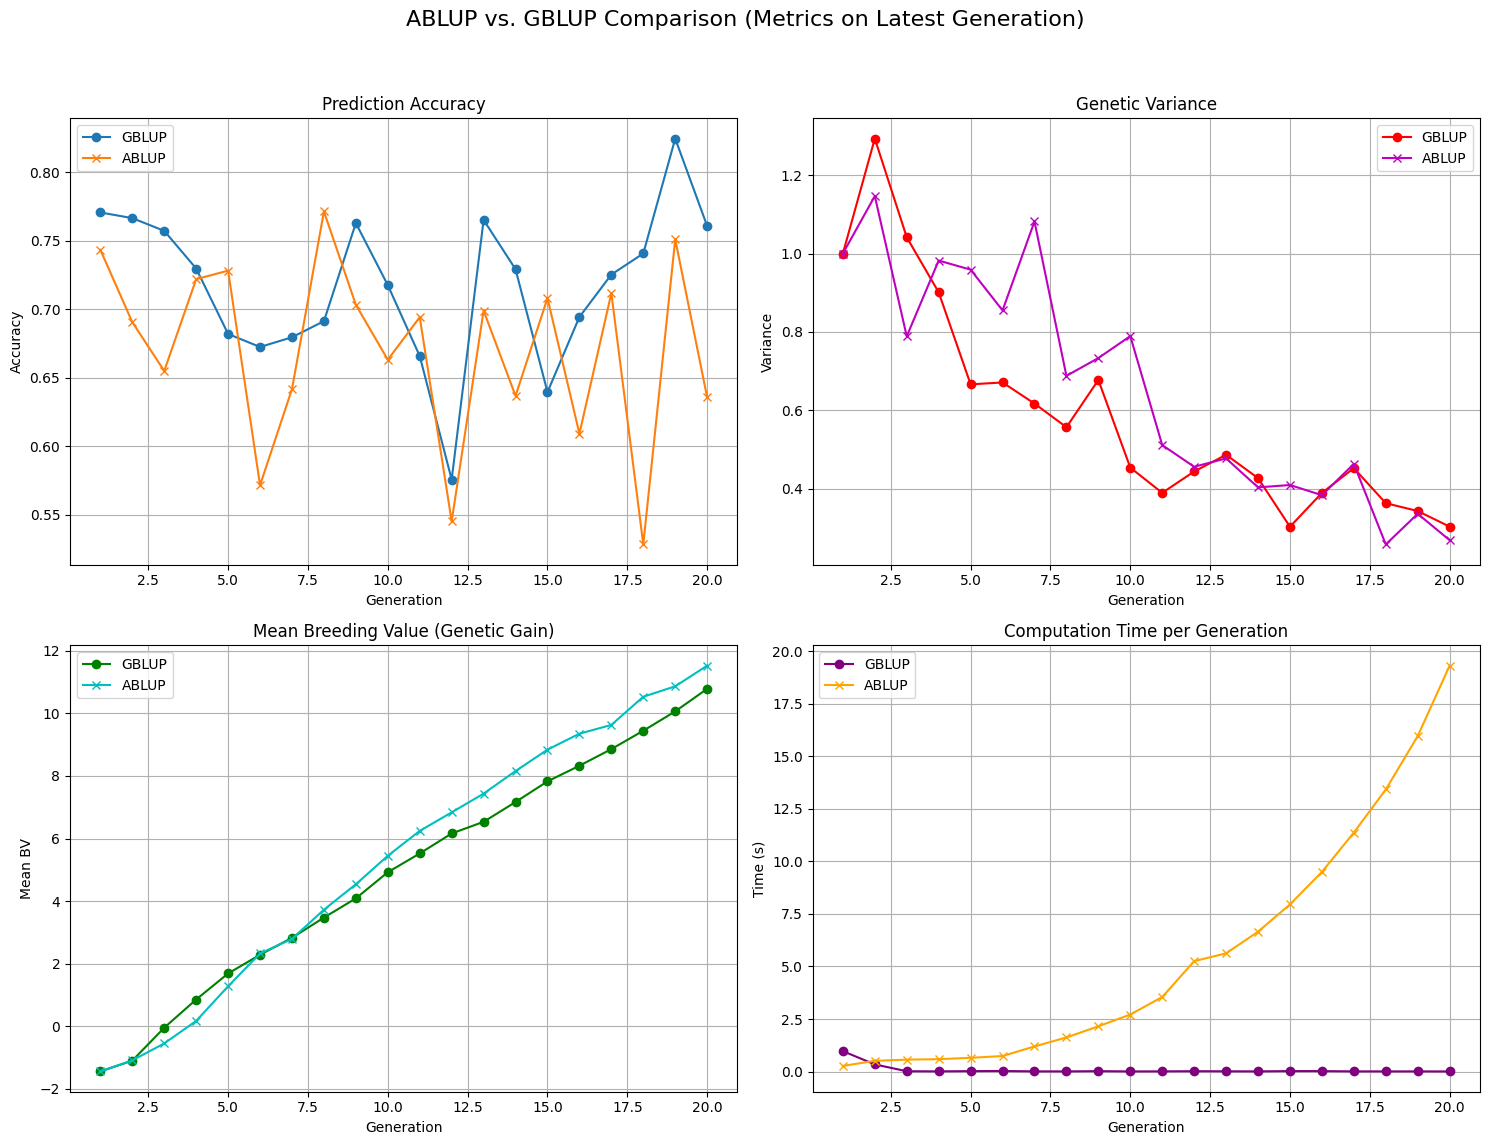

In [3]:
import jax
import jax.numpy as jnp
from jax import lax
from functools import partial
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Literal, Dict, Optional
from flax.struct import dataclass as flax_dataclass
from jax.scipy.sparse.linalg import cg
import copy

# --- Import all necessary functions from your codebase ---
# Make sure these paths are correct for your project structure
from chewc.population import Population, msprime_pop, combine_populations
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_bv, set_pheno
from chewc.cross import make_cross

# ==================================================
# --- Unified DataClass for Prediction Results ---
# ==================================================
@flax_dataclass(frozen=True)
class PredictionResults:
    ids: jnp.ndarray
    ebv: jnp.ndarray
    pev: Optional[jnp.ndarray] = None
    reliability: Optional[jnp.ndarray] = None
    fixed_effects: Optional[jnp.ndarray] = None
    h2_used: Optional[float] = None
    var_components: Optional[Dict] = None

# ==================================================
# --- Core Matrix Calculation Functions ---
# ==================================================
@partial(jax.jit, static_argnames=('n_ind',))
def _jit_calc_a_inverse(mother_iids: jnp.ndarray, father_iids: jnp.ndarray, n_ind: int) -> jnp.ndarray:
    initial_A_inv = jnp.zeros((n_ind, n_ind))
    def loop_body(i, A_inv):
        sire_iid, dam_iid = father_iids[i], mother_iids[i]
        case_index = (sire_iid != -1) + 2 * (dam_iid != -1)
        def case_0(mat): return mat.at[i, i].add(1.0)
        def case_1(mat): return mat.at[i, i].add(4/3.).at[sire_iid, sire_iid].add(1/3.).at[i, sire_iid].add(-2/3.).at[sire_iid, i].add(-2/3.)
        def case_2(mat): return mat.at[i, i].add(4/3.).at[dam_iid, dam_iid].add(1/3.).at[i, dam_iid].add(-2/3.).at[dam_iid, i].add(-2/3.)
        def case_3(mat): return (mat.at[i, i].add(2.0).at[sire_iid, sire_iid].add(0.5).at[dam_iid, dam_iid].add(0.5)
                               .at[sire_iid, dam_iid].add(0.5).at[dam_iid, sire_iid].add(0.5).at[i, sire_iid].add(-1.0)
                               .at[sire_iid, i].add(-1.0).at[i, dam_iid].add(-1.0).at[dam_iid, i].add(-1.0))
        return lax.switch(case_index, [case_0, case_1, case_2, case_3], A_inv)
    return lax.fori_loop(0, n_ind, loop_body, initial_A_inv)

def calc_a_inverse_matrix_pedigree_jax(pop: Population) -> jnp.ndarray:
    n_ind = pop.nInd
    id_to_iid_map = jnp.full(pop.id.max() + 2, -1, dtype=jnp.int32).at[pop.id].set(pop.iid)
    mother_iids = jnp.where(pop.mother < 0, -1, id_to_iid_map[pop.mother.clip(min=0)])
    father_iids = jnp.where(pop.father < 0, -1, id_to_iid_map[pop.father.clip(min=0)])
    return _jit_calc_a_inverse(mother_iids, father_iids, n_ind)

@jax.jit
def calc_g_matrix(geno_dosage: jnp.ndarray) -> jnp.ndarray:
    n_ind, n_markers = geno_dosage.shape
    p = jnp.mean(geno_dosage, axis=0) / 2.0
    P = 2 * p
    M = geno_dosage - P
    denominator = 2 * jnp.sum(p * (1 - p))
    G = (M @ M.T) / denominator
    epsilon = 1e-4
    return G + jnp.identity(n_ind) * epsilon

# ==================================================
# --- Unified Mixed Model Solver ---
# ==================================================
@partial(jax.jit, static_argnames='n_ind')
def _mme_solver_cg(pheno: jnp.ndarray, train_mask: jnp.ndarray, K_inv: jnp.ndarray, h2: float, n_ind: int) -> tuple[jnp.ndarray, jnp.ndarray]:
    alpha = (1.0 - h2) / h2
    y = jnp.nan_to_num(pheno.flatten())
    train_mask_float = train_mask.astype(jnp.float32)

    def lhs_matvec(solution_vector):
        beta = solution_vector[0]
        u = solution_vector[1:]
        xtx_beta = jnp.sum(train_mask_float) * beta
        xtz_u = jnp.sum(u * train_mask_float)
        ztx_beta = train_mask_float * beta
        ztz_u_plus_kinv_u = u * train_mask_float + alpha * (K_inv @ u)
        return jnp.concatenate([jnp.array([xtx_beta + xtz_u]), ztx_beta + ztz_u_plus_kinv_u])

    rhs = jnp.concatenate([jnp.array([jnp.sum(y * train_mask_float)]), y])
    M_diag = jnp.concatenate([jnp.array([jnp.sum(train_mask_float)]), train_mask_float + alpha * jnp.diag(K_inv)])
    M_diag = jnp.maximum(M_diag, 1e-6)
    solutions, _ = cg(lhs_matvec, rhs, M=lambda x: x / M_diag)
    return solutions[0:1], solutions[1:]

# ==================================================
# --- Prediction Functions (ABLUP and GBLUP) ---
# ==================================================
def mme_predict_ablup(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx:trait_idx+1]
    n_ind = pop.nInd
    train_mask = ~jnp.isnan(pheno.flatten())
    if jnp.sum(train_mask) == 0:
        raise ValueError("No individuals with phenotypes.")
    K_inv = calc_a_inverse_matrix_pedigree_jax(pop)
    fixed_effects, all_ebv = _mme_solver_cg(pheno, train_mask, K_inv, h2, n_ind)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1), fixed_effects=fixed_effects, h2_used=h2)

def mme_predict_gblup(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx:trait_idx+1]
    n_ind = pop.nInd
    train_mask = ~jnp.isnan(pheno.flatten())
    if jnp.sum(train_mask) == 0:
        raise ValueError("No individuals with phenotypes.")
    G = calc_g_matrix(pop.dosage)
    K_inv = jnp.linalg.inv(G)
    fixed_effects, all_ebv = _mme_solver_cg(pheno, train_mask, K_inv, h2, n_ind)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1), fixed_effects=fixed_effects, h2_used=h2)

# ==================================================
# --- Main Simulation Function ---
# ==================================================
def run_simulation(simulation_parameters: Dict, founder_pop: Population, sp: SimParam):
    prediction_method = simulation_parameters.get("prediction_method", "gblup").lower()
    print(f"--- Starting {prediction_method.upper()} Benchmark ---")

    # --- Initial Setup ---
    key = simulation_parameters["key"]
    key, pheno_key = jax.random.split(key)
    current_pop = set_pheno(key=pheno_key, pop=founder_pop, traits=sp.traits,
                            ploidy=sp.ploidy, h2=simulation_parameters["h2"])

    # --- Data storage for results ---
    genetic_variances, accuracies, mean_bvs = [], [], []
    population_sizes, timings = [], []

    # --- Generational Loop ---
    for gen in range(simulation_parameters["n_generations"]):
        print(f"\n--- Generation {gen + 1}/{simulation_parameters['n_generations']} ---")

        # 1. --- Prediction ---
        start_time = time.perf_counter()
        if prediction_method == "ablup":
            results = mme_predict_ablup(pop=current_pop, h2=simulation_parameters["h2"][0])
        else: # gblup
            results = mme_predict_gblup(pop=current_pop, h2=simulation_parameters["h2"][0])
        results.ebv.block_until_ready()
        duration = time.perf_counter() - start_time
        timings.append(duration)
        current_pop = current_pop.replace(ebv=results.ebv)

        # ========================= THE FIX =========================
        # 2. --- Reporting & Metric Calculation (on LATEST generation) ---
        # This ensures a fair comparison between overlapping (ABLUP) and
        # non-overlapping (GBLUP) generation schemes.
        latest_gen_num = current_pop.gen.max()
        latest_gen_mask = (current_pop.gen == latest_gen_num)

        accuracy = jnp.corrcoef(
            current_pop.bv[latest_gen_mask].flatten(),
            current_pop.ebv[latest_gen_mask].flatten()
        )[0, 1]
        variance = jnp.var(current_pop.bv[latest_gen_mask])
        mean_bv = jnp.mean(current_pop.bv[latest_gen_mask])

        accuracies.append(accuracy)
        genetic_variances.append(variance)
        mean_bvs.append(mean_bv)
        # =========================================================

        pop_size = current_pop.nInd
        population_sizes.append(pop_size)

        print(f"  -> Total Population Size: {pop_size}")
        print(f"  -> Latest Gen Size: {jnp.sum(latest_gen_mask)}")
        print(f"  -> Prediction Time: {duration:.4f}s")
        print(f"  -> Prediction Accuracy (Latest Gen): {accuracy:.4f}")
        print(f"  -> Genetic Variance (Latest Gen):    {variance:.4f}")

        # 3. --- Selection ---
        ebvs, sexes = current_pop.ebv[:, 0], current_pop.sex
        male_iids = current_pop.iid[sexes == 1]
        female_iids = current_pop.iid[sexes == 0]
        num_males_to_select = min(simulation_parameters['n_select_male'], len(male_iids))
        num_females_to_select = min(simulation_parameters['n_select_female'], len(female_iids))
        top_male_iids = male_iids[jnp.argsort(ebvs[male_iids])[-num_males_to_select:]]
        top_female_iids = female_iids[jnp.argsort(ebvs[female_iids])[-num_females_to_select:]]

        # 4. --- Mating & Creating the NEXT Generation ---
        key, select_key, cross_key, pheno_key = jax.random.split(key, 4)
        sires = jax.random.choice(select_key, top_male_iids, shape=(simulation_parameters['population_size'],), replace=True)
        dams = jax.random.choice(select_key, top_female_iids, shape=(simulation_parameters['population_size'],), replace=True)
        cross_plan = jnp.stack([dams, sires], axis=1)

        progeny_pop = make_cross(key=cross_key, pop=current_pop, cross_plan=cross_plan, sp=sp,
                                 next_id_start=current_pop.id.max() + 1)
        progeny_pop = set_pheno(key=pheno_key, pop=progeny_pop, traits=sp.traits,
                                ploidy=sp.ploidy, h2=simulation_parameters["h2"])

        # 5. --- Update Population ---
        if simulation_parameters.get("overlapping_generations", False):
             current_pop = combine_populations(current_pop, progeny_pop)
        else:
             current_pop = progeny_pop

        # 6. --- Termination Check ---
        if variance < 1e-4:
            print(f"\nTERMINATING: Genetic variance in latest generation is exhausted.")
            break

    return {
        "accuracies": accuracies,
        "genetic_variances": genetic_variances,
        "mean_bvs": mean_bvs,
        "timings": timings,
        "population_sizes": population_sizes
    }

if __name__ == '__main__':
    base_simulation_parameters = {
        "n_founder_ind": 50, "n_loci_per_chr": 1000, "n_chr": 5, "n_qtl_per_chr": 100,
        "trait_mean": jnp.array([0.0]), "trait_var": jnp.array([1.0]), "n_generations": 20,
        "population_size": 200, "n_select_male": 10, "n_select_female": 50,
        "key": jax.random.PRNGKey(42), "h2": jnp.array([.4]),
    }

    key, founder_key, sp1_key = jax.random.split(base_simulation_parameters["key"], 3)
    founder_pop, genetic_map = msprime_pop(
        key=founder_key, n_ind=base_simulation_parameters["n_founder_ind"],
        n_loci_per_chr=base_simulation_parameters["n_loci_per_chr"], n_chr=base_simulation_parameters["n_chr"])
    sp = SimParam.from_founder_pop(founder_pop, genetic_map)
    sp = add_trait_a(
        key=sp1_key, founder_pop=founder_pop, sim_param=sp,
        n_qtl_per_chr=base_simulation_parameters["n_qtl_per_chr"],
        mean=base_simulation_parameters["trait_mean"], var=base_simulation_parameters["trait_var"])

    gblup_params = copy.deepcopy(base_simulation_parameters)
    gblup_params["prediction_method"] = "gblup"
    gblup_params["overlapping_generations"] = False
    gblup_results = run_simulation(gblup_params, founder_pop, sp)

    ablup_params = copy.deepcopy(base_simulation_parameters)
    ablup_params["prediction_method"] = "ablup"
    ablup_params["overlapping_generations"] = True
    ablup_results = run_simulation(ablup_params, founder_pop, sp)

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("ABLUP vs. GBLUP Comparison (Metrics on Latest Generation)", fontsize=16)
    generations_gblup = np.arange(1, len(gblup_results['accuracies']) + 1)
    generations_ablup = np.arange(1, len(ablup_results['accuracies']) + 1)

    axs[0, 0].plot(generations_gblup, gblup_results['accuracies'], marker='o', label="GBLUP")
    axs[0, 0].plot(generations_ablup, ablup_results['accuracies'], marker='x', label="ABLUP")
    axs[0, 0].set_title('Prediction Accuracy')
    axs[0, 0].set_xlabel('Generation')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].grid(True); axs[0, 0].legend()

    axs[0, 1].plot(generations_gblup, gblup_results['genetic_variances'], marker='o', color='r', label="GBLUP")
    axs[0, 1].plot(generations_ablup, ablup_results['genetic_variances'], marker='x', color='m', label="ABLUP")
    axs[0, 1].set_title('Genetic Variance')
    axs[0, 1].set_xlabel('Generation')
    axs[0, 1].set_ylabel('Variance')
    axs[0, 1].grid(True); axs[0, 1].legend()

    axs[1, 0].plot(generations_gblup, gblup_results['mean_bvs'], marker='o', color='g', label="GBLUP")
    axs[1, 0].plot(generations_ablup, ablup_results['mean_bvs'], marker='x', color='c', label="ABLUP")
    axs[1, 0].set_title('Mean Breeding Value (Genetic Gain)')
    axs[1, 0].set_xlabel('Generation')
    axs[1, 0].set_ylabel('Mean BV')
    axs[1, 0].grid(True); axs[1, 0].legend()

    axs[1, 1].plot(generations_gblup, gblup_results['timings'], marker='o', color='purple', label="GBLUP")
    axs[1, 1].plot(generations_ablup, ablup_results['timings'], marker='x', color='orange', label="ABLUP")
    axs[1, 1].set_title('Computation Time per Generation')
    axs[1, 1].set_xlabel('Generation')
    axs[1, 1].set_ylabel('Time (s)')
    axs[1, 1].grid(True); axs[1, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

--- Starting GBLUP Benchmark ---

--- Generation 1/20 ---
  -> Total Population Size: 20
  -> Latest Gen Size: 20
  -> Prediction Time: 0.7575s
  -> Prediction Accuracy (Latest Gen): 0.8618
  -> Genetic Variance (Latest Gen):    1.0000

--- Generation 2/20 ---
  -> Total Population Size: 50
  -> Latest Gen Size: 50
  -> Prediction Time: 0.5329s
  -> Prediction Accuracy (Latest Gen): 0.6851
  -> Genetic Variance (Latest Gen):    0.3885

--- Generation 3/20 ---
  -> Total Population Size: 50
  -> Latest Gen Size: 50
  -> Prediction Time: 0.0065s
  -> Prediction Accuracy (Latest Gen): 0.7765
  -> Genetic Variance (Latest Gen):    0.3841

--- Generation 4/20 ---
  -> Total Population Size: 50
  -> Latest Gen Size: 50
  -> Prediction Time: 0.0164s
  -> Prediction Accuracy (Latest Gen): 0.7701
  -> Genetic Variance (Latest Gen):    0.2336

--- Generation 5/20 ---
  -> Total Population Size: 50
  -> Latest Gen Size: 50
  -> Prediction Time: 0.0131s
  -> Prediction Accuracy (Latest Gen): 0.750

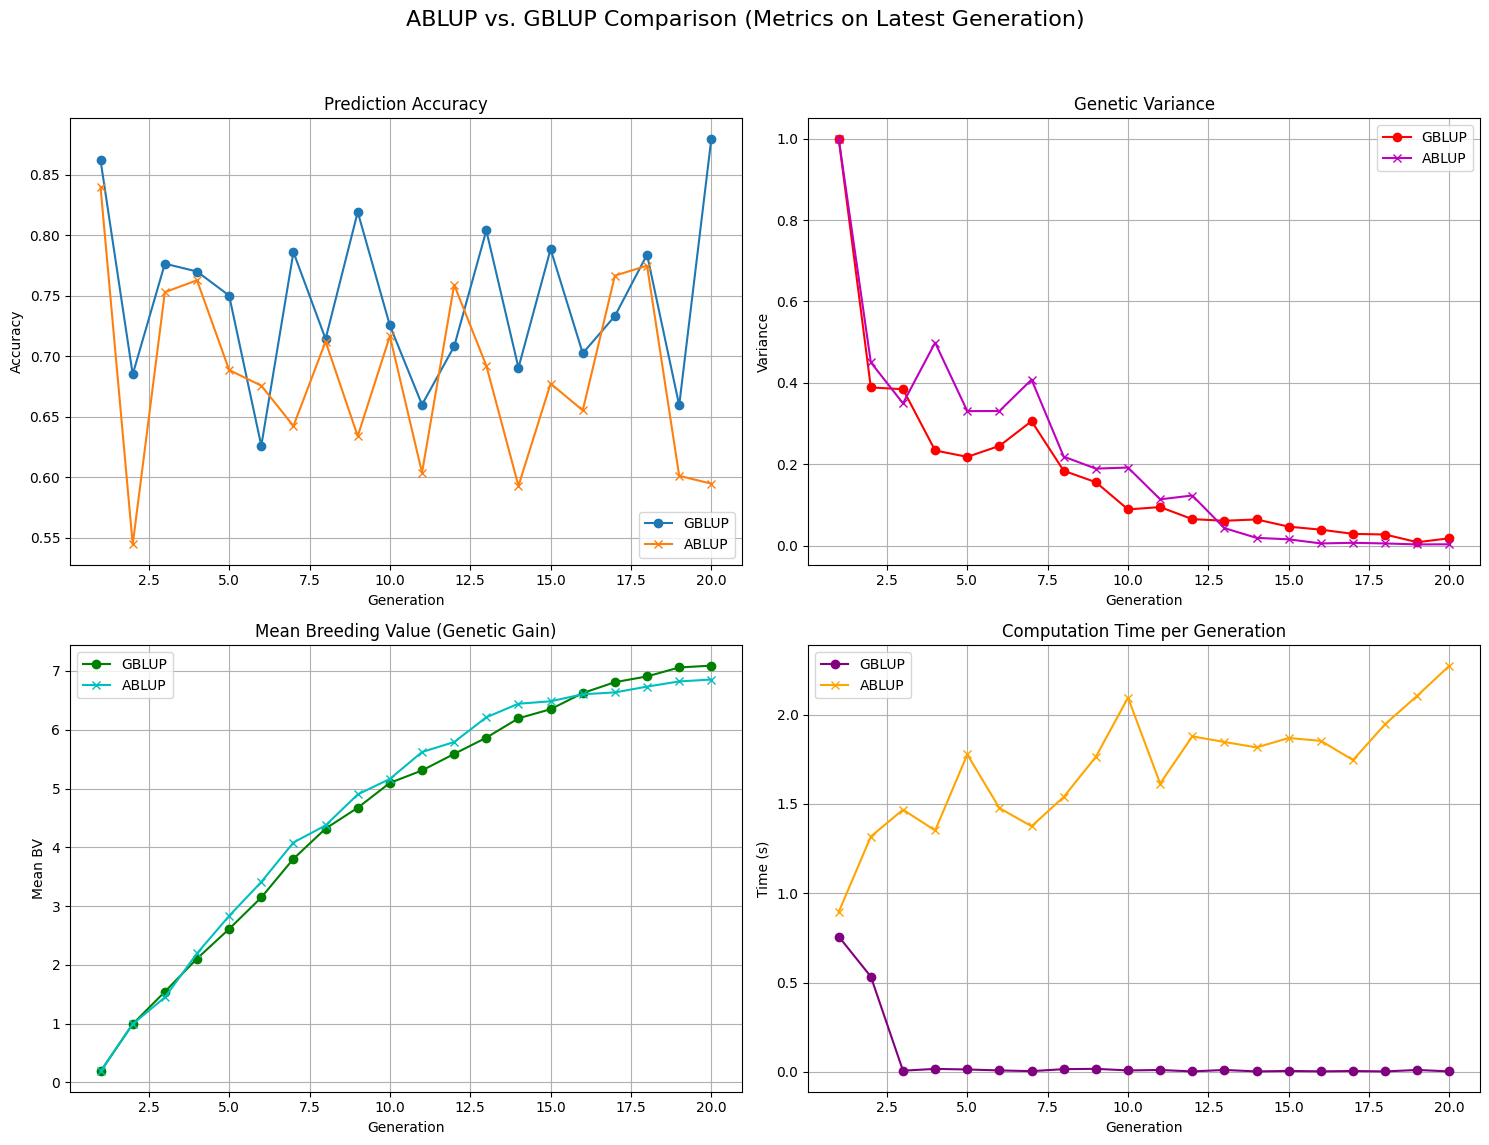

In [ ]:
import jax
import jax.numpy as jnp
from jax import lax
from functools import partial
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Literal, Dict, Optional
from flax.struct import dataclass as flax_dataclass
from jax.scipy.sparse.linalg import cg
import copy

# --- Import all necessary functions from your codebase ---
# Make sure these paths are correct for your project structure
from chewc.population import Population, msprime_pop, combine_populations
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_bv, set_pheno
from chewc.cross import make_cross

# ==================================================
# --- Unified DataClass for Prediction Results ---
# ==================================================
@flax_dataclass(frozen=True)
class PredictionResults:
    ids: jnp.ndarray
    ebv: jnp.ndarray
    pev: Optional[jnp.ndarray] = None
    reliability: Optional[jnp.ndarray] = None
    fixed_effects: Optional[jnp.ndarray] = None
    h2_used: Optional[float] = None
    var_components: Optional[Dict] = None

# ==================================================
# --- Core Matrix Calculation Functions ---
# ==================================================
@partial(jax.jit, static_argnames=('n_ind',))
def _jit_calc_a_inverse(mother_iids: jnp.ndarray, father_iids: jnp.ndarray, n_ind: int) -> jnp.ndarray:
    initial_A_inv = jnp.zeros((n_ind, n_ind))
    def loop_body(i, A_inv):
        sire_iid, dam_iid = father_iids[i], mother_iids[i]
        case_index = (sire_iid != -1) + 2 * (dam_iid != -1)
        def case_0(mat): return mat.at[i, i].add(1.0)
        def case_1(mat): return mat.at[i, i].add(4/3.).at[sire_iid, sire_iid].add(1/3.).at[i, sire_iid].add(-2/3.).at[sire_iid, i].add(-2/3.)
        def case_2(mat): return mat.at[i, i].add(4/3.).at[dam_iid, dam_iid].add(1/3.).at[i, dam_iid].add(-2/3.).at[dam_iid, i].add(-2/3.)
        def case_3(mat): return (mat.at[i, i].add(2.0).at[sire_iid, sire_iid].add(0.5).at[dam_iid, dam_iid].add(0.5)
                               .at[sire_iid, dam_iid].add(0.5).at[dam_iid, sire_iid].add(0.5).at[i, sire_iid].add(-1.0)
                               .at[sire_iid, i].add(-1.0).at[i, dam_iid].add(-1.0).at[dam_iid, i].add(-1.0))
        return lax.switch(case_index, [case_0, case_1, case_2, case_3], A_inv)
    return lax.fori_loop(0, n_ind, loop_body, initial_A_inv)

def calc_a_inverse_matrix_pedigree_jax(pop: Population) -> jnp.ndarray:
    n_ind = pop.nInd
    id_to_iid_map = jnp.full(pop.id.max() + 2, -1, dtype=jnp.int32).at[pop.id].set(pop.iid)
    mother_iids = jnp.where(pop.mother < 0, -1, id_to_iid_map[pop.mother.clip(min=0)])
    father_iids = jnp.where(pop.father < 0, -1, id_to_iid_map[pop.father.clip(min=0)])
    return _jit_calc_a_inverse(mother_iids, father_iids, n_ind)

@jax.jit
def calc_g_matrix(geno_dosage: jnp.ndarray) -> jnp.ndarray:
    n_ind, n_markers = geno_dosage.shape
    p = jnp.mean(geno_dosage, axis=0) / 2.0
    P = 2 * p
    M = geno_dosage - P
    denominator = 2 * jnp.sum(p * (1 - p))
    G = (M @ M.T) / denominator
    epsilon = 1e-4
    return G + jnp.identity(n_ind) * epsilon

# ==================================================
# --- Unified Mixed Model Solver ---
# ==================================================
@partial(jax.jit, static_argnames='n_ind')
def _mme_solver_cg(pheno: jnp.ndarray, train_mask: jnp.ndarray, K_inv: jnp.ndarray, h2: float, n_ind: int) -> tuple[jnp.ndarray, jnp.ndarray]:
    alpha = (1.0 - h2) / h2
    y = jnp.nan_to_num(pheno.flatten())
    train_mask_float = train_mask.astype(jnp.float32)

    def lhs_matvec(solution_vector):
        beta, u = solution_vector[0], solution_vector[1:]
        xtx_beta = jnp.sum(train_mask_float) * beta
        xtz_u = jnp.sum(u * train_mask_float)
        ztx_beta = train_mask_float * beta
        ztz_u_plus_kinv_u = u * train_mask_float + alpha * (K_inv @ u)
        return jnp.concatenate([jnp.array([xtx_beta + xtz_u]), ztx_beta + ztz_u_plus_kinv_u])

    rhs = jnp.concatenate([jnp.array([jnp.sum(y * train_mask_float)]), y])
    M_diag = jnp.concatenate([jnp.array([jnp.sum(train_mask_float)]), train_mask_float + alpha * jnp.diag(K_inv)])
    M_diag = jnp.maximum(M_diag, 1e-6)
    solutions, _ = cg(lhs_matvec, rhs, M=lambda x: x / M_diag)
    return solutions[0:1], solutions[1:]

# ==================================================
# --- Prediction Functions (ABLUP and GBLUP) ---
# ==================================================
def mme_predict_ablup(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx:trait_idx+1]
    n_ind = pop.nInd
    train_mask = ~jnp.isnan(pheno.flatten())
    if jnp.sum(train_mask) == 0: raise ValueError("No individuals with phenotypes.")
    K_inv = calc_a_inverse_matrix_pedigree_jax(pop)
    fixed_effects, all_ebv = _mme_solver_cg(pheno, train_mask, K_inv, h2, n_ind)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1), fixed_effects=fixed_effects, h2_used=h2)

def mme_predict_gblup(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx:trait_idx+1]
    n_ind = pop.nInd
    train_mask = ~jnp.isnan(pheno.flatten())
    if jnp.sum(train_mask) == 0: raise ValueError("No individuals with phenotypes.")
    G = calc_g_matrix(pop.dosage)
    K_inv = jnp.linalg.inv(G)
    fixed_effects, all_ebv = _mme_solver_cg(pheno, train_mask, K_inv, h2, n_ind)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1), fixed_effects=fixed_effects, h2_used=h2)

# ==================================================
# --- Main Simulation Function ---
# ==================================================
def run_simulation(simulation_parameters: Dict, founder_pop: Population, sp: SimParam):
    prediction_method = simulation_parameters.get("prediction_method", "gblup").lower()
    print(f"--- Starting {prediction_method.upper()} Benchmark ---")

    key = simulation_parameters["key"]
    key, pheno_key = jax.random.split(key)
    current_pop = set_pheno(key=pheno_key, pop=founder_pop, traits=sp.traits,
                            ploidy=sp.ploidy, h2=simulation_parameters["h2"])

    genetic_variances, accuracies, mean_bvs = [], [], []
    population_sizes, timings = [], []

    for gen in range(simulation_parameters["n_generations"]):
        print(f"\n--- Generation {gen + 1}/{simulation_parameters['n_generations']} ---")

        # 1. --- Prediction ---
        start_time = time.perf_counter()
        if prediction_method == "ablup":
            results = mme_predict_ablup(pop=current_pop, h2=simulation_parameters["h2"][0])
        else:
            results = mme_predict_gblup(pop=current_pop, h2=simulation_parameters["h2"][0])
        results.ebv.block_until_ready()
        duration = time.perf_counter() - start_time
        timings.append(duration)
        current_pop = current_pop.replace(ebv=results.ebv)

        # 2. --- Reporting & Metric Calculation (on LATEST generation) ---
        latest_gen_num = current_pop.gen.max()
        latest_gen_mask = (current_pop.gen == latest_gen_num)
        accuracy = jnp.corrcoef(
            current_pop.bv[latest_gen_mask].flatten(),
            current_pop.ebv[latest_gen_mask].flatten()
        )[0, 1]
        variance = jnp.var(current_pop.bv[latest_gen_mask])
        mean_bv = jnp.mean(current_pop.bv[latest_gen_mask])
        accuracies.append(accuracy); genetic_variances.append(variance); mean_bvs.append(mean_bv)

        pop_size = current_pop.nInd
        population_sizes.append(pop_size)
        print(f"  -> Total Population Size: {pop_size}")
        print(f"  -> Latest Gen Size: {jnp.sum(latest_gen_mask)}")
        print(f"  -> Prediction Time: {duration:.4f}s")
        print(f"  -> Prediction Accuracy (Latest Gen): {accuracy:.4f}")
        print(f"  -> Genetic Variance (Latest Gen):    {variance:.4f}")

        # ========================= MODIFIED LOGIC =========================
        # 3. --- Selection (No Sex Separation) ---
        ebvs = current_pop.ebv[:, 0]
        n_parents = simulation_parameters['n_parents']
        
        # Get iids of the top parents based on EBV
        top_parent_iids = current_pop.iid[jnp.argsort(ebvs)[-n_parents:]]

        # 4. --- Mating & Creating the NEXT Generation ---
        key, p1_key, p2_key, cross_key, pheno_key = jax.random.split(key, 5)
        n_progeny = simulation_parameters['population_size']
        
        # Randomly sample two parents for each cross from the top parents pool
        parent1 = jax.random.choice(p1_key, top_parent_iids, shape=(n_progeny,), replace=True)
        parent2 = jax.random.choice(p2_key, top_parent_iids, shape=(n_progeny,), replace=True)
        cross_plan = jnp.stack([parent1, parent2], axis=1)
        # ================================================================

        progeny_pop = make_cross(key=cross_key, pop=current_pop, cross_plan=cross_plan, sp=sp,
                                 next_id_start=current_pop.id.max() + 1)
        progeny_pop = set_pheno(key=pheno_key, pop=progeny_pop, traits=sp.traits,
                                ploidy=sp.ploidy, h2=simulation_parameters["h2"])

        # 5. --- Update Population ---
        if simulation_parameters.get("overlapping_generations", False):
             current_pop = combine_populations(current_pop, progeny_pop)
        else:   
             current_pop = progeny_pop

        # 6. --- Termination Check ---
        if variance < 1e-4:
            print(f"\nTERMINATING: Genetic variance in latest generation is exhausted.")
            break

    return {
        "accuracies": accuracies, "genetic_variances": genetic_variances, "mean_bvs": mean_bvs,
        "timings": timings, "population_sizes": population_sizes
    }


if __name__ == '__main__':
    base_simulation_parameters = {
        "n_founder_ind": 20, "n_loci_per_chr": 1000, "n_chr": 5, "n_qtl_per_chr": 100,
        "trait_mean": jnp.array([0.0]), "trait_var": jnp.array([1.0]), "n_generations": 20,
        "population_size": 50, "n_parents": 10, # Replaced n_select_male/female
        "key": jax.random.PRNGKey(42), "h2": jnp.array([.4]),
    }

    key, founder_key, sp1_key = jax.random.split(base_simulation_parameters["key"], 3)
    founder_pop, genetic_map = msprime_pop(
        key=founder_key, n_ind=base_simulation_parameters["n_founder_ind"],
        n_loci_per_chr=base_simulation_parameters["n_loci_per_chr"], n_chr=base_simulation_parameters["n_chr"])
    sp = SimParam.from_founder_pop(founder_pop, genetic_map)
    sp = add_trait_a(
        key=sp1_key, founder_pop=founder_pop, sim_param=sp,
        n_qtl_per_chr=base_simulation_parameters["n_qtl_per_chr"],
        mean=base_simulation_parameters["trait_mean"], var=base_simulation_parameters["trait_var"])

    gblup_params = copy.deepcopy(base_simulation_parameters)
    gblup_params["prediction_method"] = "gblup"
    gblup_params["overlapping_generations"] = False
    gblup_results = run_simulation(gblup_params, founder_pop, sp)

    ablup_params = copy.deepcopy(base_simulation_parameters)
    ablup_params["prediction_method"] = "ablup"
    ablup_params["overlapping_generations"] = True
    ablup_results = run_simulation(ablup_params, founder_pop, sp)

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("ABLUP vs. GBLUP Comparison (Metrics on Latest Generation)", fontsize=16)
    generations_gblup = np.arange(1, len(gblup_results['accuracies']) + 1)
    generations_ablup = np.arange(1, len(ablup_results['accuracies']) + 1)

    axs[0, 0].plot(generations_gblup, gblup_results['accuracies'], marker='o', label="GBLUP")
    axs[0, 0].plot(generations_ablup, ablup_results['accuracies'], marker='x', label="ABLUP")
    axs[0, 0].set_title('Prediction Accuracy')
    axs[0, 0].set_xlabel('Generation')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].grid(True); axs[0, 0].legend()

    axs[0, 1].plot(generations_gblup, gblup_results['genetic_variances'], marker='o', color='r', label="GBLUP")
    axs[0, 1].plot(generations_ablup, ablup_results['genetic_variances'], marker='x', color='m', label="ABLUP")
    axs[0, 1].set_title('Genetic Variance')
    axs[0, 1].set_xlabel('Generation')
    axs[0, 1].set_ylabel('Variance')
    axs[0, 1].grid(True); axs[0, 1].legend()

    axs[1, 0].plot(generations_gblup, gblup_results['mean_bvs'], marker='o', color='g', label="GBLUP")
    axs[1, 0].plot(generations_ablup, ablup_results['mean_bvs'], marker='x', color='c', label="ABLUP")
    axs[1, 0].set_title('Mean Breeding Value (Genetic Gain)')
    axs[1, 0].set_xlabel('Generation')
    axs[1, 0].set_ylabel('Mean BV')
    axs[1, 0].grid(True); axs[1, 0].legend()

    axs[1, 1].plot(generations_gblup, gblup_results['timings'], marker='o', color='purple', label="GBLUP")
    axs[1, 1].plot(generations_ablup, ablup_results['timings'], marker='x', color='orange', label="ABLUP")
    axs[1, 1].set_title('Computation Time per Generation')
    axs[1, 1].set_xlabel('Generation')
    axs[1, 1].set_ylabel('Time (s)')
    axs[1, 1].grid(True); axs[1, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

/mnt/c/Users/cltng/gdrive/chewc/chewc/population.py:432: UserWarning: Small founder population size (5) with enforce_founder_maf=True may result in few usable markers. Consider increasing n_ind or setting enforce_founder_maf=False.
  warnings.warn(



==================== Replicate 1/10 ====================
--- Starting GBLUP Benchmark ---

--- Generation 1/20 ---
  -> Total Population Size: 5
  -> Latest Gen Size: 5
  -> Prediction Time: 0.8257s
  -> Prediction Accuracy (Latest Gen): -0.1386
  -> Genetic Variance (Latest Gen):    1.0000

--- Generation 2/20 ---
  -> Total Population Size: 100
  -> Latest Gen Size: 100
  -> Prediction Time: 0.8883s
  -> Prediction Accuracy (Latest Gen): 0.7543
  -> Genetic Variance (Latest Gen):    1.3119

--- Generation 3/20 ---
  -> Total Population Size: 100
  -> Latest Gen Size: 100
  -> Prediction Time: 0.0040s
  -> Prediction Accuracy (Latest Gen): 0.7578
  -> Genetic Variance (Latest Gen):    1.0272

--- Generation 4/20 ---
  -> Total Population Size: 100
  -> Latest Gen Size: 100
  -> Prediction Time: 0.0073s
  -> Prediction Accuracy (Latest Gen): 0.6307
  -> Genetic Variance (Latest Gen):    0.6756

--- Generation 5/20 ---
  -> Total Population Size: 100
  -> Latest Gen Size: 100
  -> Pred

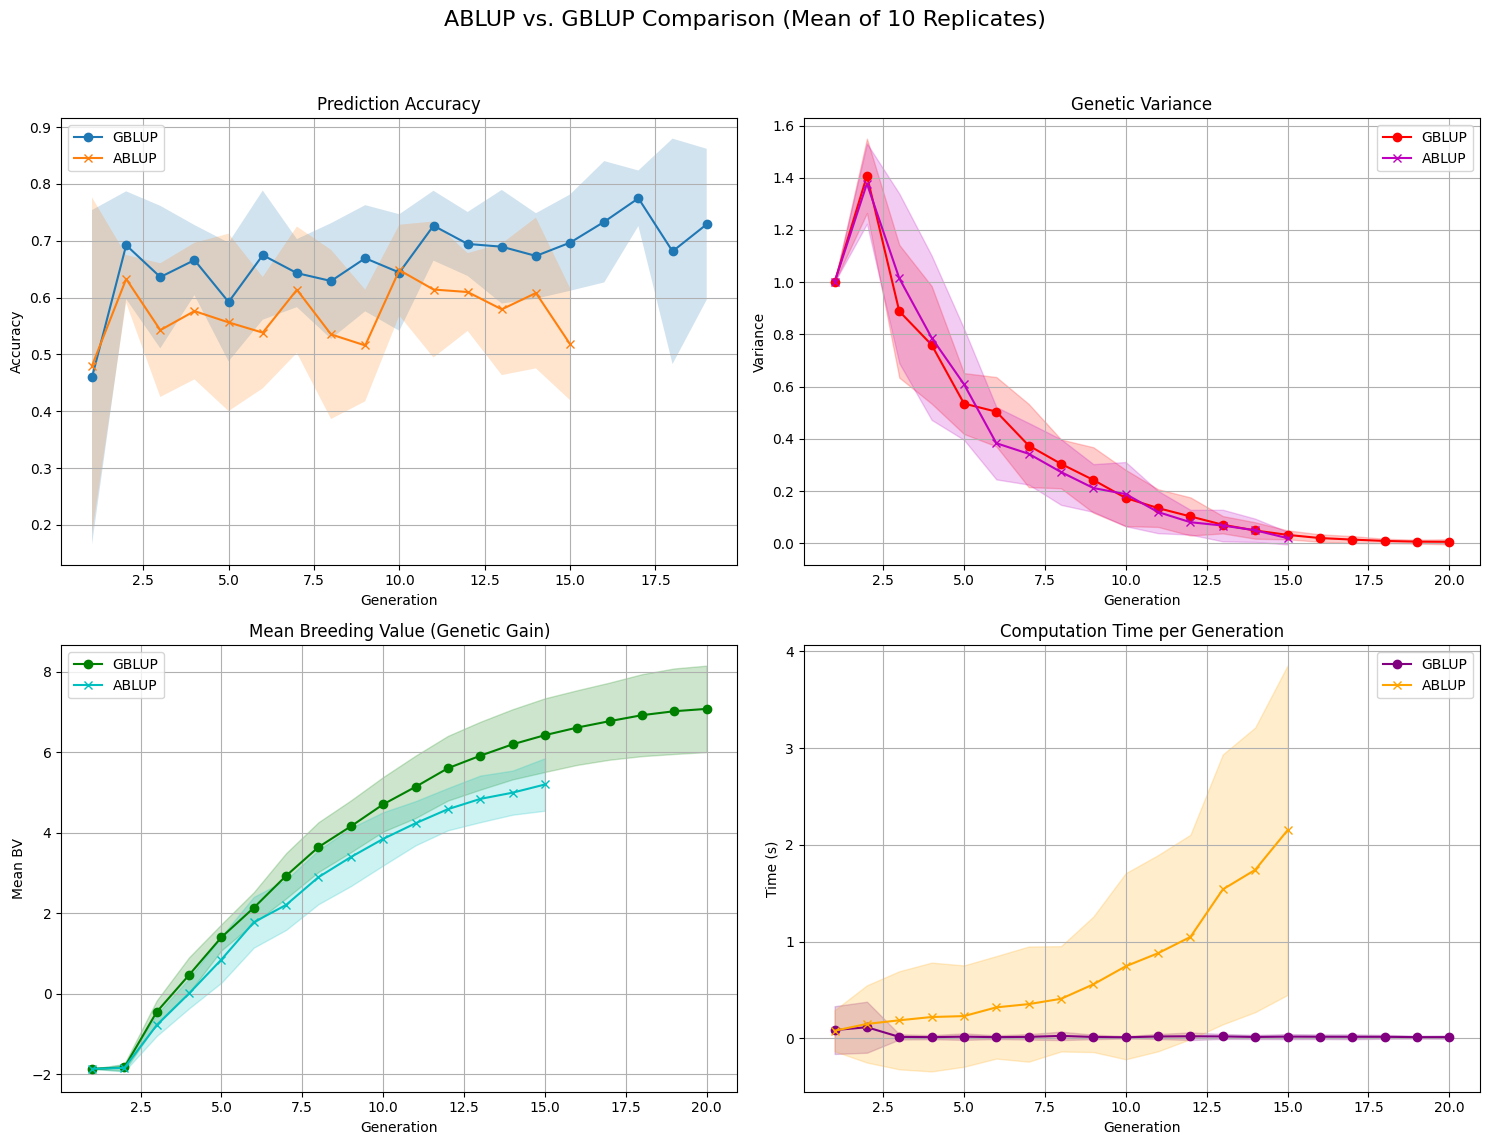

In [7]:
import jax
import jax.numpy as jnp
from jax import lax
from functools import partial
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Literal, Dict, Optional
from flax.struct import dataclass as flax_dataclass
from jax.scipy.sparse.linalg import cg
import copy

# --- Import all necessary functions from your codebase ---
# Make sure these paths are correct for your project structure
from chewc.population import Population, msprime_pop, combine_populations
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_bv, set_pheno
from chewc.cross import make_cross

# ==================================================
# --- Unified DataClass for Prediction Results ---
# ==================================================
@flax_dataclass(frozen=True)
class PredictionResults:
    ids: jnp.ndarray
    ebv: jnp.ndarray
    pev: Optional[jnp.ndarray] = None
    reliability: Optional[jnp.ndarray] = None
    fixed_effects: Optional[jnp.ndarray] = None
    h2_used: Optional[float] = None
    var_components: Optional[Dict] = None

# ==================================================
# --- Core Matrix Calculation Functions ---
# ==================================================
@partial(jax.jit, static_argnames=('n_ind',))
def _jit_calc_a_inverse(mother_iids: jnp.ndarray, father_iids: jnp.ndarray, n_ind: int) -> jnp.ndarray:
    initial_A_inv = jnp.zeros((n_ind, n_ind))
    def loop_body(i, A_inv):
        sire_iid, dam_iid = father_iids[i], mother_iids[i]
        case_index = (sire_iid != -1) + 2 * (dam_iid != -1)
        def case_0(mat): return mat.at[i, i].add(1.0)
        def case_1(mat): return mat.at[i, i].add(4/3.).at[sire_iid, sire_iid].add(1/3.).at[i, sire_iid].add(-2/3.).at[sire_iid, i].add(-2/3.)
        def case_2(mat): return mat.at[i, i].add(4/3.).at[dam_iid, dam_iid].add(1/3.).at[i, dam_iid].add(-2/3.).at[dam_iid, i].add(-2/3.)
        def case_3(mat): return (mat.at[i, i].add(2.0).at[sire_iid, sire_iid].add(0.5).at[dam_iid, dam_iid].add(0.5)
                               .at[sire_iid, dam_iid].add(0.5).at[dam_iid, sire_iid].add(0.5).at[i, sire_iid].add(-1.0)
                               .at[sire_iid, i].add(-1.0).at[i, dam_iid].add(-1.0).at[dam_iid, i].add(-1.0))
        return lax.switch(case_index, [case_0, case_1, case_2, case_3], A_inv)
    return lax.fori_loop(0, n_ind, loop_body, initial_A_inv)

def calc_a_inverse_matrix_pedigree_jax(pop: Population) -> jnp.ndarray:
    n_ind = pop.nInd
    id_to_iid_map = jnp.full(pop.id.max() + 2, -1, dtype=jnp.int32).at[pop.id].set(pop.iid)
    mother_iids = jnp.where(pop.mother < 0, -1, id_to_iid_map[pop.mother.clip(min=0)])
    father_iids = jnp.where(pop.father < 0, -1, id_to_iid_map[pop.father.clip(min=0)])
    return _jit_calc_a_inverse(mother_iids, father_iids, n_ind)

@jax.jit
def calc_g_matrix(geno_dosage: jnp.ndarray) -> jnp.ndarray:
    n_ind, n_markers = geno_dosage.shape
    p = jnp.mean(geno_dosage, axis=0) / 2.0
    P = 2 * p
    M = geno_dosage - P
    denominator = 2 * jnp.sum(p * (1 - p))
    G = (M @ M.T) / denominator
    epsilon = 1e-4
    return G + jnp.identity(n_ind) * epsilon

# ==================================================
# --- Unified Mixed Model Solver ---
# ==================================================
@partial(jax.jit, static_argnames='n_ind')
def _mme_solver_cg(pheno: jnp.ndarray, train_mask: jnp.ndarray, K_inv: jnp.ndarray, h2: float, n_ind: int) -> tuple[jnp.ndarray, jnp.ndarray]:
    alpha = (1.0 - h2) / h2
    y = jnp.nan_to_num(pheno.flatten())
    train_mask_float = train_mask.astype(jnp.float32)

    def lhs_matvec(solution_vector):
        beta, u = solution_vector[0], solution_vector[1:]
        xtx_beta = jnp.sum(train_mask_float) * beta
        xtz_u = jnp.sum(u * train_mask_float)
        ztx_beta = train_mask_float * beta
        ztz_u_plus_kinv_u = u * train_mask_float + alpha * (K_inv @ u)
        return jnp.concatenate([jnp.array([xtx_beta + xtz_u]), ztx_beta + ztz_u_plus_kinv_u])

    rhs = jnp.concatenate([jnp.array([jnp.sum(y * train_mask_float)]), y])
    M_diag = jnp.concatenate([jnp.array([jnp.sum(train_mask_float)]), train_mask_float + alpha * jnp.diag(K_inv)])
    M_diag = jnp.maximum(M_diag, 1e-6)
    solutions, _ = cg(lhs_matvec, rhs, M=lambda x: x / M_diag)
    return solutions[0:1], solutions[1:]

# ==================================================
# --- Prediction Functions (ABLUP and GBLUP) ---
# ==================================================
def mme_predict_ablup(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx:trait_idx+1]
    n_ind = pop.nInd
    train_mask = ~jnp.isnan(pheno.flatten())
    if jnp.sum(train_mask) == 0: raise ValueError("No individuals with phenotypes.")
    K_inv = calc_a_inverse_matrix_pedigree_jax(pop)
    fixed_effects, all_ebv = _mme_solver_cg(pheno, train_mask, K_inv, h2, n_ind)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1), fixed_effects=fixed_effects, h2_used=h2)

def mme_predict_gblup(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx:trait_idx+1]
    n_ind = pop.nInd
    train_mask = ~jnp.isnan(pheno.flatten())
    if jnp.sum(train_mask) == 0: raise ValueError("No individuals with phenotypes.")
    G = calc_g_matrix(pop.dosage)
    K_inv = jnp.linalg.inv(G)
    fixed_effects, all_ebv = _mme_solver_cg(pheno, train_mask, K_inv, h2, n_ind)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1), fixed_effects=fixed_effects, h2_used=h2)

# ==================================================
# --- Main Simulation Function ---
# ==================================================
def run_simulation(simulation_parameters: Dict, founder_pop: Population, sp: SimParam):
    prediction_method = simulation_parameters.get("prediction_method", "gblup").lower()
    print(f"--- Starting {prediction_method.upper()} Benchmark ---")

    key = simulation_parameters["key"]
    key, pheno_key = jax.random.split(key)
    current_pop = set_pheno(key=pheno_key, pop=founder_pop, traits=sp.traits,
                            ploidy=sp.ploidy, h2=simulation_parameters["h2"])

    genetic_variances, accuracies, mean_bvs = [], [], []
    population_sizes, timings = [], []

    for gen in range(simulation_parameters["n_generations"]):
        print(f"\n--- Generation {gen + 1}/{simulation_parameters['n_generations']} ---")

        # 1. --- Prediction ---
        start_time = time.perf_counter()
        if prediction_method == "ablup":
            results = mme_predict_ablup(pop=current_pop, h2=simulation_parameters["h2"][0])
        else:
            results = mme_predict_gblup(pop=current_pop, h2=simulation_parameters["h2"][0])
        results.ebv.block_until_ready()
        duration = time.perf_counter() - start_time
        timings.append(duration)
        current_pop = current_pop.replace(ebv=results.ebv)

        # 2. --- Reporting & Metric Calculation (on LATEST generation) ---
        latest_gen_num = current_pop.gen.max()
        latest_gen_mask = (current_pop.gen == latest_gen_num)
        accuracy = jnp.corrcoef(
            current_pop.bv[latest_gen_mask].flatten(),
            current_pop.ebv[latest_gen_mask].flatten()
        )[0, 1]
        variance = jnp.var(current_pop.bv[latest_gen_mask])
        mean_bv = jnp.mean(current_pop.bv[latest_gen_mask])
        accuracies.append(accuracy); genetic_variances.append(variance); mean_bvs.append(mean_bv)

        pop_size = current_pop.nInd
        population_sizes.append(pop_size)
        print(f"  -> Total Population Size: {pop_size}")
        print(f"  -> Latest Gen Size: {jnp.sum(latest_gen_mask)}")
        print(f"  -> Prediction Time: {duration:.4f}s")
        print(f"  -> Prediction Accuracy (Latest Gen): {accuracy:.4f}")
        print(f"  -> Genetic Variance (Latest Gen):    {variance:.4f}")

        # 3. --- Selection (No Sex Separation) ---
        ebvs = current_pop.ebv[:, 0]
        n_parents = simulation_parameters['n_parents']
        top_parent_iids = current_pop.iid[jnp.argsort(ebvs)[-n_parents:]]

        # 4. --- Mating & Creating the NEXT Generation ---
        key, p1_key, p2_key, cross_key, pheno_key = jax.random.split(key, 5)
        n_progeny = simulation_parameters['population_size']
        parent1 = jax.random.choice(p1_key, top_parent_iids, shape=(n_progeny,), replace=True)
        parent2 = jax.random.choice(p2_key, top_parent_iids, shape=(n_progeny,), replace=True)
        cross_plan = jnp.stack([parent1, parent2], axis=1)

        progeny_pop = make_cross(key=cross_key, pop=current_pop, cross_plan=cross_plan, sp=sp,
                                 next_id_start=current_pop.id.max() + 1)
        progeny_pop = set_pheno(key=pheno_key, pop=progeny_pop, traits=sp.traits,
                                ploidy=sp.ploidy, h2=simulation_parameters["h2"])

        # 5. --- Update Population ---
        if simulation_parameters.get("overlapping_generations", False):
             current_pop = combine_populations(current_pop, progeny_pop)
        else:
             current_pop = progeny_pop

        # 6. --- Termination Check ---
        if variance < 1e-4:
            print(f"\nTERMINATING: Genetic variance in latest generation is exhausted.")
            break

    return {
        "accuracies": accuracies, "genetic_variances": genetic_variances, "mean_bvs": mean_bvs,
        "timings": timings, "population_sizes": population_sizes
    }


if __name__ == '__main__':
    base_simulation_parameters = {
        "n_founder_ind": 5, "n_loci_per_chr": 1000, "n_chr": 5, "n_qtl_per_chr": 100,
        "trait_mean": jnp.array([0.0]), "trait_var": jnp.array([1.0]), "n_generations": 20,
        "population_size": 100, "n_parents": 10,
        "key": jax.random.PRNGKey(42), "h2": jnp.array([.2]),
        "n_replicates": 10
    }

    # --- Create a single founder population for all simulations ---
    key, founder_key, sp1_key = jax.random.split(base_simulation_parameters["key"], 3)
    founder_pop, genetic_map = msprime_pop(
        key=founder_key, n_ind=base_simulation_parameters["n_founder_ind"],
        n_loci_per_chr=base_simulation_parameters["n_loci_per_chr"], n_chr=base_simulation_parameters["n_chr"])
    sp = SimParam.from_founder_pop(founder_pop, genetic_map)
    sp = add_trait_a(
        key=sp1_key, founder_pop=founder_pop, sim_param=sp,
        n_qtl_per_chr=base_simulation_parameters["n_qtl_per_chr"],
        mean=base_simulation_parameters["trait_mean"], var=base_simulation_parameters["trait_var"])

    # --- Store results for all replicates ---
    all_gblup_results = []
    all_ablup_results = []

    # --- Run Replicates ---
    master_key = base_simulation_parameters["key"]
    for i in range(base_simulation_parameters["n_replicates"]):
        print(f"\n{'='*20} Replicate {i+1}/{base_simulation_parameters['n_replicates']} {'='*20}")
        rep_key, master_key = jax.random.split(master_key)

        # --- GBLUP ---
        gblup_params = copy.deepcopy(base_simulation_parameters)
        gblup_params["prediction_method"] = "gblup"
        gblup_params["overlapping_generations"] = False
        gblup_params["key"] = rep_key
        all_gblup_results.append(run_simulation(gblup_params, founder_pop, sp))

        # --- ABLUP ---
        ablup_params = copy.deepcopy(base_simulation_parameters)
        ablup_params["prediction_method"] = "ablup"
        ablup_params["overlapping_generations"] = True
        ablup_params["key"] = rep_key
        all_ablup_results.append(run_simulation(ablup_params, founder_pop, sp))


    # --- Aggregate and Plot Results ---
    def aggregate_results(all_results):
        # Find the minimum number of generations across all replicates
        min_len = min(len(r['accuracies']) for r in all_results)
        
        # Truncate all results to the minimum length
        truncated_results = {}
        for key in all_results[0].keys():
            truncated_results[key] = [r[key][:min_len] for r in all_results]

        # Calculate mean and std dev
        aggregated = {}
        for key, values in truncated_results.items():
            aggregated[f"{key}_mean"] = np.mean(values, axis=0)
            aggregated[f"{key}_std"] = np.std(values, axis=0)
        return aggregated, min_len

    gblup_agg, gblup_len = aggregate_results(all_gblup_results)
    ablup_agg, ablup_len = aggregate_results(all_ablup_results)


    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f"ABLUP vs. GBLUP Comparison (Mean of {base_simulation_parameters['n_replicates']} Replicates)", fontsize=16)
    
    generations_gblup = np.arange(1, gblup_len + 1)
    generations_ablup = np.arange(1, ablup_len + 1)

    # Accuracy Plot
    for agg, generations, label in [(gblup_agg, generations_gblup, "GBLUP"), (ablup_agg, generations_ablup, "ABLUP")]:
        axs[0, 0].plot(generations, agg['accuracies_mean'], marker='o' if label == 'GBLUP' else 'x', label=label)
        axs[0, 0].fill_between(generations, agg['accuracies_mean'] - agg['accuracies_std'],
                               agg['accuracies_mean'] + agg['accuracies_std'], alpha=0.2)
    axs[0, 0].set_title('Prediction Accuracy')
    axs[0, 0].set_xlabel('Generation')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].grid(True); axs[0, 0].legend()

    # Genetic Variance Plot
    for agg, generations, label, color in [(gblup_agg, generations_gblup, "GBLUP", 'r'), (ablup_agg, generations_ablup, "ABLUP", 'm')]:
        axs[0, 1].plot(generations, agg['genetic_variances_mean'], marker='o' if label == 'GBLUP' else 'x', label=label, color=color)
        axs[0, 1].fill_between(generations, agg['genetic_variances_mean'] - agg['genetic_variances_std'],
                               agg['genetic_variances_mean'] + agg['genetic_variances_std'], alpha=0.2, color=color)
    axs[0, 1].set_title('Genetic Variance')
    axs[0, 1].set_xlabel('Generation')
    axs[0, 1].set_ylabel('Variance')
    axs[0, 1].grid(True); axs[0, 1].legend()

    # Mean Breeding Value Plot
    for agg, generations, label, color in [(gblup_agg, generations_gblup, "GBLUP", 'g'), (ablup_agg, generations_ablup, "ABLUP", 'c')]:
        axs[1, 0].plot(generations, agg['mean_bvs_mean'], marker='o' if label == 'GBLUP' else 'x', label=label, color=color)
        axs[1, 0].fill_between(generations, agg['mean_bvs_mean'] - agg['mean_bvs_std'],
                               agg['mean_bvs_mean'] + agg['mean_bvs_std'], alpha=0.2, color=color)
    axs[1, 0].set_title('Mean Breeding Value (Genetic Gain)')
    axs[1, 0].set_xlabel('Generation')
    axs[1, 0].set_ylabel('Mean BV')
    axs[1, 0].grid(True); axs[1, 0].legend()

    # Timings Plot
    for agg, generations, label, color in [(gblup_agg, generations_gblup, "GBLUP", 'purple'), (ablup_agg, generations_ablup, "ABLUP", 'orange')]:
        axs[1, 1].plot(generations, agg['timings_mean'], marker='o' if label == 'GBLUP' else 'x', label=label, color=color)
        axs[1, 1].fill_between(generations, agg['timings_mean'] - agg['timings_std'],
                               agg['timings_mean'] + agg['timings_std'], alpha=0.2, color=color)
    axs[1, 1].set_title('Computation Time per Generation')
    axs[1, 1].set_xlabel('Generation')
    axs[1, 1].set_ylabel('Time (s)')
    axs[1, 1].grid(True); axs[1, 1].legend()


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

/mnt/c/Users/cltng/gdrive/chewc/chewc/population.py:432: UserWarning: Small founder population size (10) with enforce_founder_maf=True may result in few usable markers. Consider increasing n_ind or setting enforce_founder_maf=False.
  warnings.warn(



==================== Replicate 1/5 ====================
--- Starting GBLUP Benchmark ---

--- Generation 1/20 ---
  -> Total Population Size: 10
  -> Latest Gen Size: 10
  -> Prediction Time: 0.8487s
  -> Prediction Accuracy (Latest Gen): 0.6362
  -> Genetic Variance (Latest Gen):    1.0000

--- Generation 2/20 ---
  -> Total Population Size: 100
  -> Latest Gen Size: 100
  -> Prediction Time: 0.4444s
  -> Prediction Accuracy (Latest Gen): 0.8339
  -> Genetic Variance (Latest Gen):    1.3041

--- Generation 3/20 ---
  -> Total Population Size: 100
  -> Latest Gen Size: 100
  -> Prediction Time: 0.0032s
  -> Prediction Accuracy (Latest Gen): 0.8371
  -> Genetic Variance (Latest Gen):    0.9544

--- Generation 4/20 ---
  -> Total Population Size: 100
  -> Latest Gen Size: 100
  -> Prediction Time: 0.0081s
  -> Prediction Accuracy (Latest Gen): 0.6417
  -> Genetic Variance (Latest Gen):    0.6216

--- Generation 5/20 ---
  -> Total Population Size: 100
  -> Latest Gen Size: 100
  -> Pred

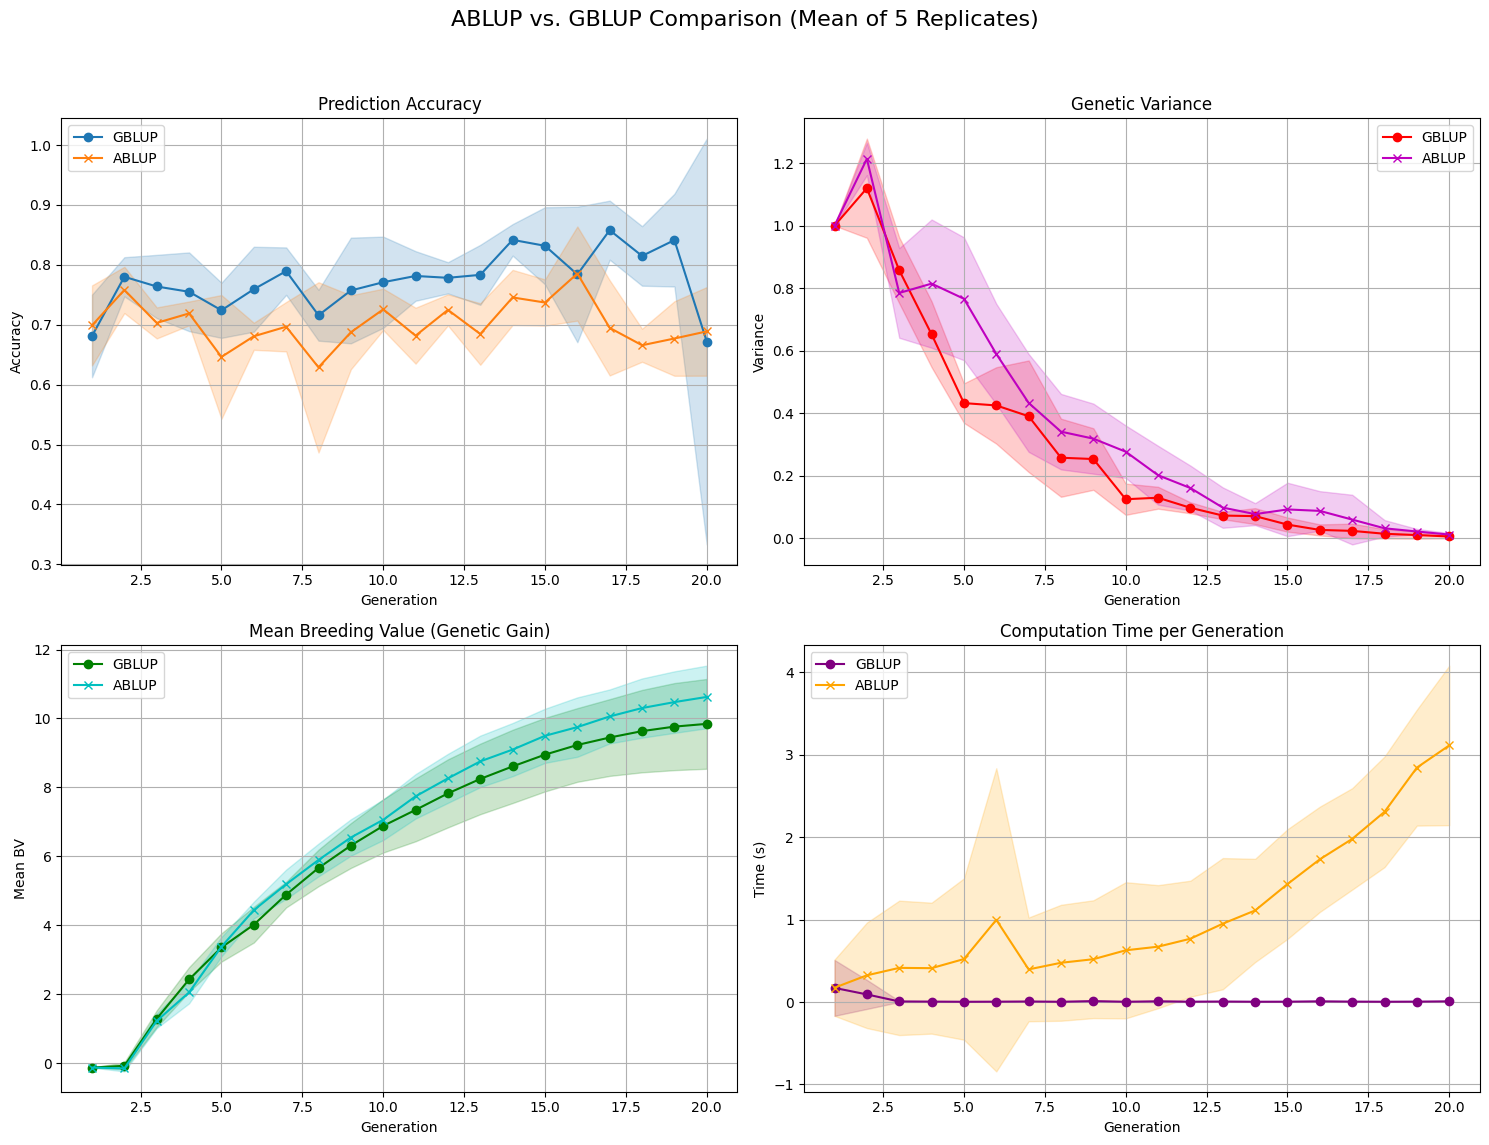

In [8]:
import jax
import jax.numpy as jnp
from jax import lax
from functools import partial
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Literal, Dict, Optional
from flax.struct import dataclass as flax_dataclass
from jax.scipy.sparse.linalg import cg
import copy

# --- Import all necessary functions from your codebase ---
# Make sure these paths are correct for your project structure
from chewc.population import Population, msprime_pop, combine_populations
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_bv, set_pheno
from chewc.cross import make_cross

# ==================================================
# --- Unified DataClass for Prediction Results ---
# ==================================================
@flax_dataclass(frozen=True)
class PredictionResults:
    ids: jnp.ndarray
    ebv: jnp.ndarray
    pev: Optional[jnp.ndarray] = None
    reliability: Optional[jnp.ndarray] = None
    fixed_effects: Optional[jnp.ndarray] = None
    h2_used: Optional[float] = None
    var_components: Optional[Dict] = None

# ==================================================
# --- Core Matrix Calculation Functions ---
# ==================================================
@partial(jax.jit, static_argnames=('n_ind',))
def _jit_calc_a_inverse(mother_iids: jnp.ndarray, father_iids: jnp.ndarray, n_ind: int) -> jnp.ndarray:
    initial_A_inv = jnp.zeros((n_ind, n_ind))
    def loop_body(i, A_inv):
        sire_iid, dam_iid = father_iids[i], mother_iids[i]
        case_index = (sire_iid != -1) + 2 * (dam_iid != -1)
        def case_0(mat): return mat.at[i, i].add(1.0)
        def case_1(mat): return mat.at[i, i].add(4/3.).at[sire_iid, sire_iid].add(1/3.).at[i, sire_iid].add(-2/3.).at[sire_iid, i].add(-2/3.)
        def case_2(mat): return mat.at[i, i].add(4/3.).at[dam_iid, dam_iid].add(1/3.).at[i, dam_iid].add(-2/3.).at[dam_iid, i].add(-2/3.)
        def case_3(mat): return (mat.at[i, i].add(2.0).at[sire_iid, sire_iid].add(0.5).at[dam_iid, dam_iid].add(0.5)
                               .at[sire_iid, dam_iid].add(0.5).at[dam_iid, sire_iid].add(0.5).at[i, sire_iid].add(-1.0)
                               .at[sire_iid, i].add(-1.0).at[i, dam_iid].add(-1.0).at[dam_iid, i].add(-1.0))
        return lax.switch(case_index, [case_0, case_1, case_2, case_3], A_inv)
    return lax.fori_loop(0, n_ind, loop_body, initial_A_inv)

def calc_a_inverse_matrix_pedigree_jax(pop: Population) -> jnp.ndarray:
    n_ind = pop.nInd
    id_to_iid_map = jnp.full(pop.id.max() + 2, -1, dtype=jnp.int32).at[pop.id].set(pop.iid)
    mother_iids = jnp.where(pop.mother < 0, -1, id_to_iid_map[pop.mother.clip(min=0)])
    father_iids = jnp.where(pop.father < 0, -1, id_to_iid_map[pop.father.clip(min=0)])
    return _jit_calc_a_inverse(mother_iids, father_iids, n_ind)

@jax.jit
def calc_g_matrix(geno_dosage: jnp.ndarray) -> jnp.ndarray:
    n_ind, n_markers = geno_dosage.shape
    p = jnp.mean(geno_dosage, axis=0) / 2.0
    P = 2 * p
    M = geno_dosage - P
    denominator = 2 * jnp.sum(p * (1 - p))
    G = (M @ M.T) / denominator
    epsilon = 1e-4
    return G + jnp.identity(n_ind) * epsilon

# ==================================================
# --- Unified Mixed Model Solver ---
# ==================================================
@partial(jax.jit, static_argnames='n_ind')
def _mme_solver_cg(pheno: jnp.ndarray, train_mask: jnp.ndarray, K_inv: jnp.ndarray, h2: float, n_ind: int) -> tuple[jnp.ndarray, jnp.ndarray]:
    alpha = (1.0 - h2) / h2
    y = jnp.nan_to_num(pheno.flatten())
    train_mask_float = train_mask.astype(jnp.float32)

    def lhs_matvec(solution_vector):
        beta, u = solution_vector[0], solution_vector[1:]
        xtx_beta = jnp.sum(train_mask_float) * beta
        xtz_u = jnp.sum(u * train_mask_float)
        ztx_beta = train_mask_float * beta
        ztz_u_plus_kinv_u = u * train_mask_float + alpha * (K_inv @ u)
        return jnp.concatenate([jnp.array([xtx_beta + xtz_u]), ztx_beta + ztz_u_plus_kinv_u])

    rhs = jnp.concatenate([jnp.array([jnp.sum(y * train_mask_float)]), y])
    M_diag = jnp.concatenate([jnp.array([jnp.sum(train_mask_float)]), train_mask_float + alpha * jnp.diag(K_inv)])
    M_diag = jnp.maximum(M_diag, 1e-6)
    solutions, _ = cg(lhs_matvec, rhs, M=lambda x: x / M_diag)
    return solutions[0:1], solutions[1:]

# ==================================================
# --- Prediction Functions (ABLUP and GBLUP) ---
# ==================================================
def mme_predict_ablup(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx:trait_idx+1]
    n_ind = pop.nInd
    train_mask = ~jnp.isnan(pheno.flatten())
    if jnp.sum(train_mask) == 0: raise ValueError("No individuals with phenotypes.")
    K_inv = calc_a_inverse_matrix_pedigree_jax(pop)
    fixed_effects, all_ebv = _mme_solver_cg(pheno, train_mask, K_inv, h2, n_ind)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1), fixed_effects=fixed_effects, h2_used=h2)

def mme_predict_gblup(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx:trait_idx+1]
    n_ind = pop.nInd
    train_mask = ~jnp.isnan(pheno.flatten())
    if jnp.sum(train_mask) == 0: raise ValueError("No individuals with phenotypes.")
    G = calc_g_matrix(pop.dosage)
    K_inv = jnp.linalg.inv(G)
    fixed_effects, all_ebv = _mme_solver_cg(pheno, train_mask, K_inv, h2, n_ind)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1), fixed_effects=fixed_effects, h2_used=h2)

# ==================================================
# --- Main Simulation Function ---
# ==================================================
def run_simulation(simulation_parameters: Dict, founder_pop: Population, sp: SimParam):
    prediction_method = simulation_parameters.get("prediction_method", "gblup").lower()
    print(f"--- Starting {prediction_method.upper()} Benchmark ---")

    key = simulation_parameters["key"]
    key, pheno_key = jax.random.split(key)
    current_pop = set_pheno(key=pheno_key, pop=founder_pop, traits=sp.traits,
                            ploidy=sp.ploidy, h2=simulation_parameters["h2"])

    genetic_variances, accuracies, mean_bvs = [], [], []
    population_sizes, timings = [], []

    for gen in range(simulation_parameters["n_generations"]):
        print(f"\n--- Generation {gen + 1}/{simulation_parameters['n_generations']} ---")

        # 1. --- Prediction ---
        start_time = time.perf_counter()
        if prediction_method == "ablup":
            results = mme_predict_ablup(pop=current_pop, h2=simulation_parameters["h2"][0])
        else:
            results = mme_predict_gblup(pop=current_pop, h2=simulation_parameters["h2"][0])
        results.ebv.block_until_ready()
        duration = time.perf_counter() - start_time
        timings.append(duration)
        current_pop = current_pop.replace(ebv=results.ebv)

        # 2. --- Reporting & Metric Calculation (on LATEST generation) ---
        latest_gen_num = current_pop.gen.max()
        latest_gen_mask = (current_pop.gen == latest_gen_num)

        # ========================= MODIFIED LOGIC =========================
        variance = jnp.var(current_pop.bv[latest_gen_mask])
        mean_bv = jnp.mean(current_pop.bv[latest_gen_mask])

        # Safeguard against NaN from corrcoef when variance is zero
        if variance < 1e-7:
            accuracy = 0.0
        else:
            accuracy = jnp.corrcoef(
                current_pop.bv[latest_gen_mask].flatten(),
                current_pop.ebv[latest_gen_mask].flatten()
            )[0, 1]
        # ================================================================

        accuracies.append(accuracy); genetic_variances.append(variance); mean_bvs.append(mean_bv)

        pop_size = current_pop.nInd
        population_sizes.append(pop_size)
        print(f"  -> Total Population Size: {pop_size}")
        print(f"  -> Latest Gen Size: {jnp.sum(latest_gen_mask)}")
        print(f"  -> Prediction Time: {duration:.4f}s")
        print(f"  -> Prediction Accuracy (Latest Gen): {accuracy:.4f}")
        print(f"  -> Genetic Variance (Latest Gen):    {variance:.4f}")

        # 3. --- Selection (No Sex Separation) ---
        ebvs = current_pop.ebv[:, 0]
        n_parents = simulation_parameters['n_parents']
        top_parent_iids = current_pop.iid[jnp.argsort(ebvs)[-n_parents:]]

        # 4. --- Mating & Creating the NEXT Generation ---
        key, p1_key, p2_key, cross_key, pheno_key = jax.random.split(key, 5)
        n_progeny = simulation_parameters['population_size']
        parent1 = jax.random.choice(p1_key, top_parent_iids, shape=(n_progeny,), replace=True)
        parent2 = jax.random.choice(p2_key, top_parent_iids, shape=(n_progeny,), replace=True)
        cross_plan = jnp.stack([parent1, parent2], axis=1)

        progeny_pop = make_cross(key=cross_key, pop=current_pop, cross_plan=cross_plan, sp=sp,
                                 next_id_start=current_pop.id.max() + 1)
        progeny_pop = set_pheno(key=pheno_key, pop=progeny_pop, traits=sp.traits,
                                ploidy=sp.ploidy, h2=simulation_parameters["h2"])

        # 5. --- Update Population ---
        if simulation_parameters.get("overlapping_generations", False):
             current_pop = combine_populations(current_pop, progeny_pop)
        else:
             current_pop = progeny_pop

        # 6. --- REMOVED early termination to allow simulation to complete
        
    return {
        "accuracies": accuracies, "genetic_variances": genetic_variances, "mean_bvs": mean_bvs,
        "timings": timings, "population_sizes": population_sizes
    }


if __name__ == '__main__':
    base_simulation_parameters = {
        "n_founder_ind": 10, "n_loci_per_chr": 1000, "n_chr": 5, "n_qtl_per_chr": 100,
        "trait_mean": jnp.array([0.0]), "trait_var": jnp.array([1.0]), "n_generations": 20,
        "population_size": 100, "n_parents": 10,
        "key": jax.random.PRNGKey(42), "h2": jnp.array([.4]),
        "n_replicates": 5
    }

    key, founder_key, sp1_key = jax.random.split(base_simulation_parameters["key"], 3)
    founder_pop, genetic_map = msprime_pop(
        key=founder_key, n_ind=base_simulation_parameters["n_founder_ind"],
        n_loci_per_chr=base_simulation_parameters["n_loci_per_chr"], n_chr=base_simulation_parameters["n_chr"])
    sp = SimParam.from_founder_pop(founder_pop, genetic_map)
    sp = add_trait_a(
        key=sp1_key, founder_pop=founder_pop, sim_param=sp,
        n_qtl_per_chr=base_simulation_parameters["n_qtl_per_chr"],
        mean=base_simulation_parameters["trait_mean"], var=base_simulation_parameters["trait_var"])

    all_gblup_results, all_ablup_results = [], []

    master_key = base_simulation_parameters["key"]
    for i in range(base_simulation_parameters["n_replicates"]):
        print(f"\n{'='*20} Replicate {i+1}/{base_simulation_parameters['n_replicates']} {'='*20}")
        rep_key, master_key = jax.random.split(master_key)

        gblup_params = copy.deepcopy(base_simulation_parameters)
        gblup_params.update({"prediction_method": "gblup", "overlapping_generations": False, "key": rep_key})
        all_gblup_results.append(run_simulation(gblup_params, founder_pop, sp))

        ablup_params = copy.deepcopy(base_simulation_parameters)
        ablup_params.update({"prediction_method": "ablup", "overlapping_generations": True, "key": rep_key})
        all_ablup_results.append(run_simulation(ablup_params, founder_pop, sp))

    def aggregate_results(all_results):
        min_len = min(len(r['accuracies']) for r in all_results)
        truncated_results = {key: [r[key][:min_len] for r in all_results] for key in all_results[0].keys()}
        aggregated = {f"{key}_mean": np.mean(values, axis=0) for key, values in truncated_results.items()}
        aggregated.update({f"{key}_std": np.std(values, axis=0) for key, values in truncated_results.items()})
        return aggregated, min_len

    gblup_agg, gblup_len = aggregate_results(all_gblup_results)
    ablup_agg, ablup_len = aggregate_results(all_ablup_results)

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f"ABLUP vs. GBLUP Comparison (Mean of {base_simulation_parameters['n_replicates']} Replicates)", fontsize=16)
    
    generations_gblup = np.arange(1, gblup_len + 1)
    generations_ablup = np.arange(1, ablup_len + 1)

    for agg, generations, label, color_map in [
        (gblup_agg, generations_gblup, "GBLUP", {'acc': 'C0', 'var': 'r', 'bv': 'g', 'time': 'purple'}),
        (ablup_agg, generations_ablup, "ABLUP", {'acc': 'C1', 'var': 'm', 'bv': 'c', 'time': 'orange'})
    ]:
        marker = 'o' if label == 'GBLUP' else 'x'
        # Accuracy Plot
        axs[0, 0].plot(generations, agg['accuracies_mean'], marker=marker, label=label, color=color_map['acc'])
        axs[0, 0].fill_between(generations, agg['accuracies_mean'] - agg['accuracies_std'],
                               agg['accuracies_mean'] + agg['accuracies_std'], alpha=0.2, color=color_map['acc'])
        # Genetic Variance Plot
        axs[0, 1].plot(generations, agg['genetic_variances_mean'], marker=marker, label=label, color=color_map['var'])
        axs[0, 1].fill_between(generations, agg['genetic_variances_mean'] - agg['genetic_variances_std'],
                               agg['genetic_variances_mean'] + agg['genetic_variances_std'], alpha=0.2, color=color_map['var'])
        # Mean BV Plot
        axs[1, 0].plot(generations, agg['mean_bvs_mean'], marker=marker, label=label, color=color_map['bv'])
        axs[1, 0].fill_between(generations, agg['mean_bvs_mean'] - agg['mean_bvs_std'],
                               agg['mean_bvs_mean'] + agg['mean_bvs_std'], alpha=0.2, color=color_map['bv'])
        # Timings Plot
        axs[1, 1].plot(generations, agg['timings_mean'], marker=marker, label=label, color=color_map['time'])
        axs[1, 1].fill_between(generations, agg['timings_mean'] - agg['timings_std'],
                               agg['timings_mean'] + agg['timings_std'], alpha=0.2, color=color_map['time'])

    axs[0, 0].set_title('Prediction Accuracy'); axs[0, 0].set_ylabel('Accuracy')
    axs[0, 1].set_title('Genetic Variance'); axs[0, 1].set_ylabel('Variance')
    axs[1, 0].set_title('Mean Breeding Value (Genetic Gain)'); axs[1, 0].set_ylabel('Mean BV')
    axs[1, 1].set_title('Computation Time per Generation'); axs[1, 1].set_ylabel('Time (s)')
    for ax in axs.flat:
        ax.set_xlabel('Generation'); ax.grid(True); ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


==================== Replicate 1/3 ====================
--- Starting GBLUP Benchmark ---

--- Generation 1/20 ---
  -> Total Population Size: 50
  -> Latest Gen Size: 50
  -> Prediction Time: 0.2892s
  -> Prediction Accuracy (Latest Gen): 0.5605
  -> Genetic Variance (Latest Gen):    1.0000

--- Generation 2/20 ---
  -> Total Population Size: 250
  -> Latest Gen Size: 200
  -> Prediction Time: 0.4362s
  -> Prediction Accuracy (Latest Gen): 0.8275
  -> Genetic Variance (Latest Gen):    0.7759

--- Generation 3/20 ---
  -> Total Population Size: 450
  -> Latest Gen Size: 200
  -> Prediction Time: 0.3629s
  -> Prediction Accuracy (Latest Gen): 0.7969
  -> Genetic Variance (Latest Gen):    0.6399

--- Generation 4/20 ---
  -> Total Population Size: 650
  -> Latest Gen Size: 200
  -> Prediction Time: 0.4874s
  -> Prediction Accuracy (Latest Gen): 0.8171
  -> Genetic Variance (Latest Gen):    0.5675

--- Generation 5/20 ---
  -> Total Population Size: 850
  -> Latest Gen Size: 200
  -> Pred

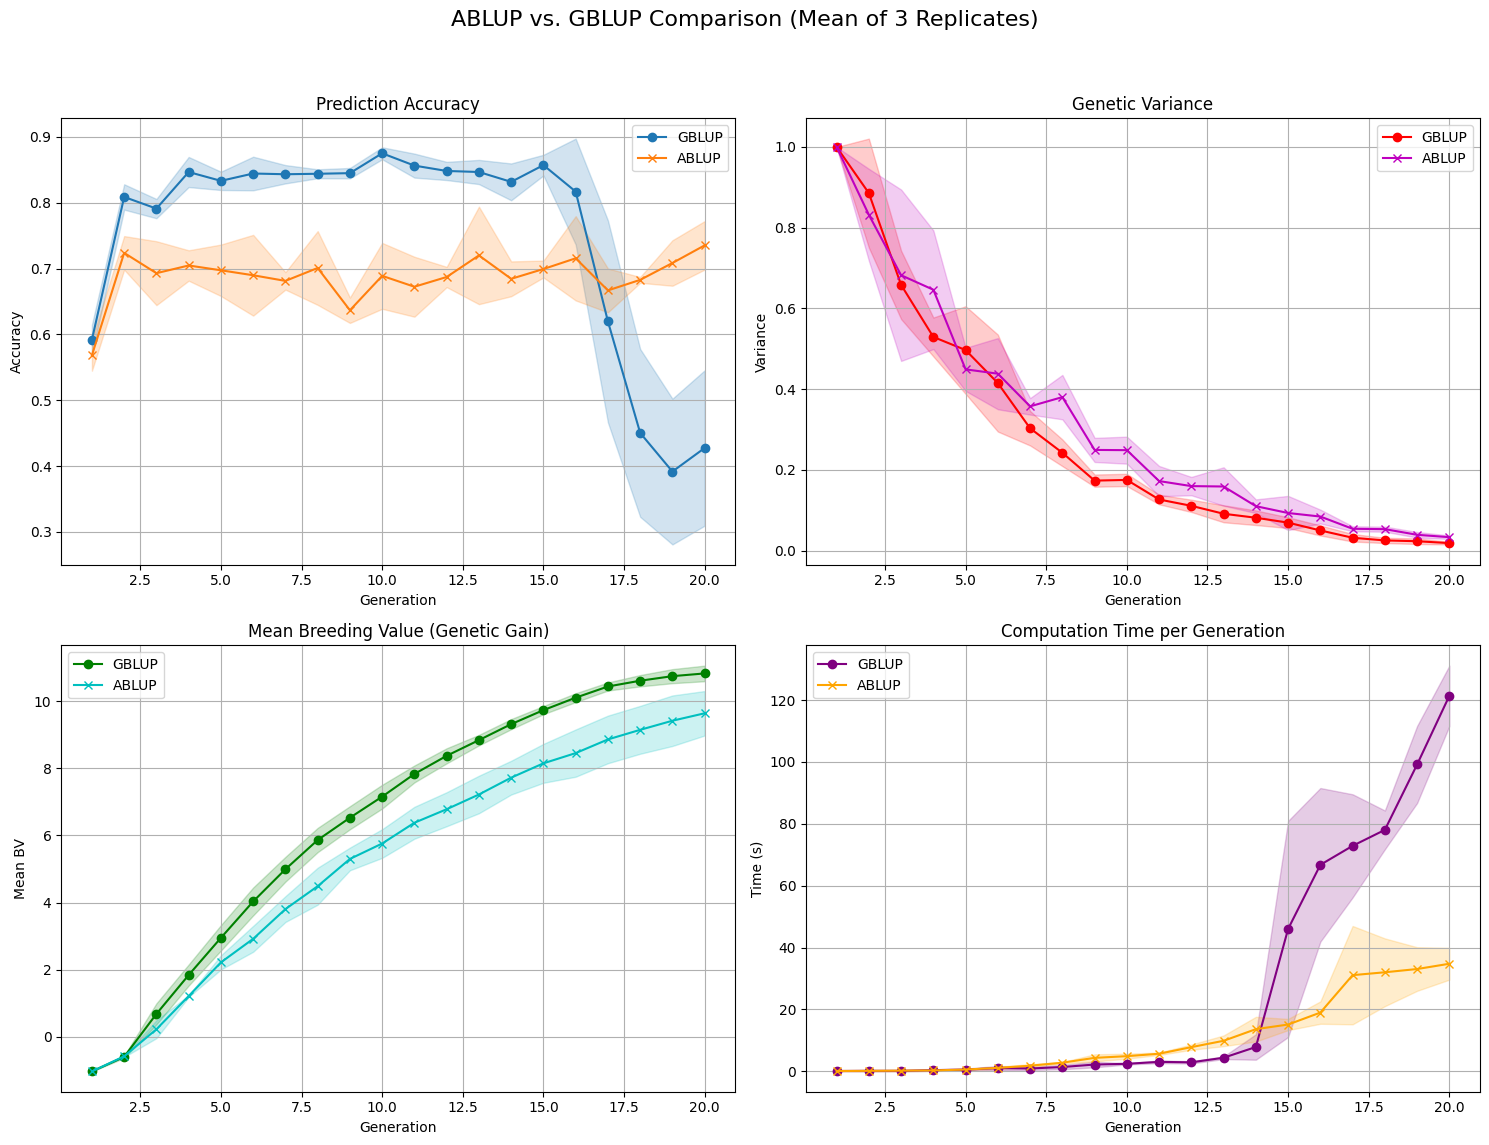

In [4]:
import jax
import jax.numpy as jnp
from jax import lax
from functools import partial
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Literal, Dict, Optional
from flax.struct import dataclass as flax_dataclass
from jax.scipy.sparse.linalg import cg
import copy

# --- Import all necessary functions from your codebase ---
# Make sure these paths are correct for your project structure
from chewc.population import Population, msprime_pop, combine_populations
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_bv, set_pheno
from chewc.cross import make_cross

# ==================================================
# --- Unified DataClass for Prediction Results ---
# ==================================================
@flax_dataclass(frozen=True)
class PredictionResults:
    ids: jnp.ndarray
    ebv: jnp.ndarray
    pev: Optional[jnp.ndarray] = None
    reliability: Optional[jnp.ndarray] = None
    fixed_effects: Optional[jnp.ndarray] = None
    h2_used: Optional[float] = None
    var_components: Optional[Dict] = None

# ==================================================
# --- Core Matrix Calculation Functions ---
# ==================================================
@partial(jax.jit, static_argnames=('n_ind',))
def _jit_calc_a_inverse(mother_iids: jnp.ndarray, father_iids: jnp.ndarray, n_ind: int) -> jnp.ndarray:
    initial_A_inv = jnp.zeros((n_ind, n_ind))
    def loop_body(i, A_inv):
        sire_iid, dam_iid = father_iids[i], mother_iids[i]
        case_index = (sire_iid != -1) + 2 * (dam_iid != -1)
        def case_0(mat): return mat.at[i, i].add(1.0)
        def case_1(mat): return mat.at[i, i].add(4/3.).at[sire_iid, sire_iid].add(1/3.).at[i, sire_iid].add(-2/3.).at[sire_iid, i].add(-2/3.)
        def case_2(mat): return mat.at[i, i].add(4/3.).at[dam_iid, dam_iid].add(1/3.).at[i, dam_iid].add(-2/3.).at[dam_iid, i].add(-2/3.)
        def case_3(mat): return (mat.at[i, i].add(2.0).at[sire_iid, sire_iid].add(0.5).at[dam_iid, dam_iid].add(0.5)
                               .at[sire_iid, dam_iid].add(0.5).at[dam_iid, sire_iid].add(0.5).at[i, sire_iid].add(-1.0)
                               .at[sire_iid, i].add(-1.0).at[i, dam_iid].add(-1.0).at[dam_iid, i].add(-1.0))
        return lax.switch(case_index, [case_0, case_1, case_2, case_3], A_inv)
    return lax.fori_loop(0, n_ind, loop_body, initial_A_inv)

def calc_a_inverse_matrix_pedigree_jax(pop: Population) -> jnp.ndarray:
    n_ind = pop.nInd
    id_to_iid_map = jnp.full(pop.id.max() + 2, -1, dtype=jnp.int32).at[pop.id].set(pop.iid)
    mother_iids = jnp.where(pop.mother < 0, -1, id_to_iid_map[pop.mother.clip(min=0)])
    father_iids = jnp.where(pop.father < 0, -1, id_to_iid_map[pop.father.clip(min=0)])
    return _jit_calc_a_inverse(mother_iids, father_iids, n_ind)

@jax.jit
def calc_g_matrix(geno_dosage: jnp.ndarray) -> jnp.ndarray:
    n_ind, n_markers = geno_dosage.shape
    p = jnp.mean(geno_dosage, axis=0) / 2.0
    P = 2 * p
    M = geno_dosage - P
    denominator = 2 * jnp.sum(p * (1 - p))
    G = (M @ M.T) / denominator
    epsilon = 1e-4
    return G + jnp.identity(n_ind) * epsilon

# ==================================================
# --- Unified Mixed Model Solver ---
# ==================================================
@partial(jax.jit, static_argnames='n_ind')
def _mme_solver_cg(pheno: jnp.ndarray, train_mask: jnp.ndarray, K_inv: jnp.ndarray, h2: float, n_ind: int) -> tuple[jnp.ndarray, jnp.ndarray]:
    alpha = (1.0 - h2) / h2
    y = jnp.nan_to_num(pheno.flatten())
    train_mask_float = train_mask.astype(jnp.float32)

    def lhs_matvec(solution_vector):
        beta, u = solution_vector[0], solution_vector[1:]
        xtx_beta = jnp.sum(train_mask_float) * beta
        xtz_u = jnp.sum(u * train_mask_float)
        ztx_beta = train_mask_float * beta
        ztz_u_plus_kinv_u = u * train_mask_float + alpha * (K_inv @ u)
        return jnp.concatenate([jnp.array([xtx_beta + xtz_u]), ztx_beta + ztz_u_plus_kinv_u])

    rhs = jnp.concatenate([jnp.array([jnp.sum(y * train_mask_float)]), y])
    M_diag = jnp.concatenate([jnp.array([jnp.sum(train_mask_float)]), train_mask_float + alpha * jnp.diag(K_inv)])
    M_diag = jnp.maximum(M_diag, 1e-6)
    solutions, _ = cg(lhs_matvec, rhs, M=lambda x: x / M_diag)
    return solutions[0:1], solutions[1:]

# ==================================================
# --- Prediction Functions (ABLUP and GBLUP) ---
# ==================================================
def mme_predict_ablup(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx:trait_idx+1]
    n_ind = pop.nInd
    train_mask = ~jnp.isnan(pheno.flatten())
    if jnp.sum(train_mask) == 0: raise ValueError("No individuals with phenotypes.")
    K_inv = calc_a_inverse_matrix_pedigree_jax(pop)
    fixed_effects, all_ebv = _mme_solver_cg(pheno, train_mask, K_inv, h2, n_ind)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1), fixed_effects=fixed_effects, h2_used=h2)

def mme_predict_gblup(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx:trait_idx+1]
    n_ind = pop.nInd
    train_mask = ~jnp.isnan(pheno.flatten())
    if jnp.sum(train_mask) == 0: raise ValueError("No individuals with phenotypes.")
    G = calc_g_matrix(pop.dosage)
    K_inv = jnp.linalg.inv(G)
    fixed_effects, all_ebv = _mme_solver_cg(pheno, train_mask, K_inv, h2, n_ind)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1), fixed_effects=fixed_effects, h2_used=h2)

# ==================================================
# --- Main Simulation Function ---
# ==================================================
def run_simulation(simulation_parameters: Dict, founder_pop: Population, sp: SimParam):
    prediction_method = simulation_parameters.get("prediction_method", "gblup").lower()
    print(f"--- Starting {prediction_method.upper()} Benchmark ---")

    key = simulation_parameters["key"]
    key, pheno_key = jax.random.split(key)
    current_pop = set_pheno(key=pheno_key, pop=founder_pop, traits=sp.traits,
                            ploidy=sp.ploidy, h2=simulation_parameters["h2"])

    genetic_variances, accuracies, mean_bvs = [], [], []
    population_sizes, timings = [], []

    for gen in range(simulation_parameters["n_generations"]):
        print(f"\n--- Generation {gen + 1}/{simulation_parameters['n_generations']} ---")

        start_time = time.perf_counter()
        if prediction_method == "ablup":
            results = mme_predict_ablup(pop=current_pop, h2=simulation_parameters["h2"][0])
        else:
            results = mme_predict_gblup(pop=current_pop, h2=simulation_parameters["h2"][0])
        results.ebv.block_until_ready()
        duration = time.perf_counter() - start_time
        timings.append(duration)
        current_pop = current_pop.replace(ebv=results.ebv)

        latest_gen_num = current_pop.gen.max()
        latest_gen_mask = (current_pop.gen == latest_gen_num)
        variance = jnp.var(current_pop.bv[latest_gen_mask])
        mean_bv = jnp.mean(current_pop.bv[latest_gen_mask])
        
        if variance < 1e-7:
            accuracy = 0.0
        else:
            accuracy = jnp.corrcoef(
                current_pop.bv[latest_gen_mask].flatten(),
                current_pop.ebv[latest_gen_mask].flatten()
            )[0, 1]

        accuracies.append(accuracy); genetic_variances.append(variance); mean_bvs.append(mean_bv)

        pop_size = current_pop.nInd
        population_sizes.append(pop_size)
        print(f"  -> Total Population Size: {pop_size}")
        print(f"  -> Latest Gen Size: {jnp.sum(latest_gen_mask)}")
        print(f"  -> Prediction Time: {duration:.4f}s")
        print(f"  -> Prediction Accuracy (Latest Gen): {accuracy:.4f}")
        print(f"  -> Genetic Variance (Latest Gen):    {variance:.4f}")

        ebvs = current_pop.ebv[:, 0]
        n_parents = simulation_parameters['n_parents']
        top_parent_iids = current_pop.iid[jnp.argsort(ebvs)[-n_parents:]]

        key, p1_key, p2_key, cross_key, pheno_key = jax.random.split(key, 5)
        n_progeny = simulation_parameters['population_size']
        parent1 = jax.random.choice(p1_key, top_parent_iids, shape=(n_progeny,), replace=True)
        parent2 = jax.random.choice(p2_key, top_parent_iids, shape=(n_progeny,), replace=True)
        cross_plan = jnp.stack([parent1, parent2], axis=1)

        progeny_pop = make_cross(key=cross_key, pop=current_pop, cross_plan=cross_plan, sp=sp,
                                 next_id_start=current_pop.id.max() + 1)
        progeny_pop = set_pheno(key=pheno_key, pop=progeny_pop, traits=sp.traits,
                                ploidy=sp.ploidy, h2=simulation_parameters["h2"])

        if simulation_parameters.get("overlapping_generations", False):
             current_pop = combine_populations(current_pop, progeny_pop)
        else:
             current_pop = progeny_pop
        
    return {
        "accuracies": accuracies, "genetic_variances": genetic_variances, "mean_bvs": mean_bvs,
        "timings": timings, "population_sizes": population_sizes
    }

if __name__ == '__main__':
    base_simulation_parameters = {
        "n_founder_ind": 50, "n_loci_per_chr": 500, "n_chr": 5, "n_qtl_per_chr": 100,
        "trait_mean": jnp.array([0.0]), "trait_var": jnp.array([1.0]), "n_generations": 20,
        "population_size": 200, "n_parents": 20,
        "key": jax.random.PRNGKey(42), "h2": jnp.array([.4]),
        "n_replicates": 3
    }

    key, founder_key, sp1_key = jax.random.split(base_simulation_parameters["key"], 3)
    founder_pop, genetic_map = msprime_pop(
        key=founder_key, n_ind=base_simulation_parameters["n_founder_ind"],
        n_loci_per_chr=base_simulation_parameters["n_loci_per_chr"], n_chr=base_simulation_parameters["n_chr"])
    sp = SimParam.from_founder_pop(founder_pop, genetic_map)
    sp = add_trait_a(
        key=sp1_key, founder_pop=founder_pop, sim_param=sp,
        n_qtl_per_chr=base_simulation_parameters["n_qtl_per_chr"],
        mean=base_simulation_parameters["trait_mean"], var=base_simulation_parameters["trait_var"])

    all_gblup_results, all_ablup_results = [], []

    master_key = base_simulation_parameters["key"]
    for i in range(base_simulation_parameters["n_replicates"]):
        print(f"\n{'='*20} Replicate {i+1}/{base_simulation_parameters['n_replicates']} {'='*20}")
        rep_key, master_key = jax.random.split(master_key)

        # --- GBLUP ---
        gblup_params = copy.deepcopy(base_simulation_parameters)
        gblup_params.update({"prediction_method": "gblup", "overlapping_generations": True, "key": rep_key}) # MODIFIED
        all_gblup_results.append(run_simulation(gblup_params, founder_pop, sp))

        # --- ABLUP ---
        ablup_params = copy.deepcopy(base_simulation_parameters)
        ablup_params.update({"prediction_method": "ablup", "overlapping_generations": True, "key": rep_key})
        all_ablup_results.append(run_simulation(ablup_params, founder_pop, sp))

    def aggregate_results(all_results):
        min_len = min(len(r['accuracies']) for r in all_results) if all_results else 0
        if not min_len: return {}, 0
        truncated_results = {key: [r[key][:min_len] for r in all_results] for key in all_results[0].keys()}
        aggregated = {f"{key}_mean": np.mean(values, axis=0) for key, values in truncated_results.items()}
        aggregated.update({f"{key}_std": np.std(values, axis=0) for key, values in truncated_results.items()})
        return aggregated, min_len

    gblup_agg, gblup_len = aggregate_results(all_gblup_results)
    ablup_agg, ablup_len = aggregate_results(all_ablup_results)

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f"ABLUP vs. GBLUP Comparison (Mean of {base_simulation_parameters['n_replicates']} Replicates)", fontsize=16)
    
    generations_gblup = np.arange(1, gblup_len + 1)
    generations_ablup = np.arange(1, ablup_len + 1)

    for agg, generations, label, color_map in [
        (gblup_agg, generations_gblup, "GBLUP", {'acc': 'C0', 'var': 'r', 'bv': 'g', 'time': 'purple'}),
        (ablup_agg, generations_ablup, "ABLUP", {'acc': 'C1', 'var': 'm', 'bv': 'c', 'time': 'orange'})
    ]:
        marker = 'o' if label == 'GBLUP' else 'x'
        axs[0, 0].plot(generations, agg['accuracies_mean'], marker=marker, label=label, color=color_map['acc'])
        axs[0, 0].fill_between(generations, agg['accuracies_mean'] - agg['accuracies_std'],
                               agg['accuracies_mean'] + agg['accuracies_std'], alpha=0.2, color=color_map['acc'])
        axs[0, 1].plot(generations, agg['genetic_variances_mean'], marker=marker, label=label, color=color_map['var'])
        axs[0, 1].fill_between(generations, agg['genetic_variances_mean'] - agg['genetic_variances_std'],
                               agg['genetic_variances_mean'] + agg['genetic_variances_std'], alpha=0.2, color=color_map['var'])
        axs[1, 0].plot(generations, agg['mean_bvs_mean'], marker=marker, label=label, color=color_map['bv'])
        axs[1, 0].fill_between(generations, agg['mean_bvs_mean'] - agg['mean_bvs_std'],
                               agg['mean_bvs_mean'] + agg['mean_bvs_std'], alpha=0.2, color=color_map['bv'])
        axs[1, 1].plot(generations, agg['timings_mean'], marker=marker, label=label, color=color_map['time'])
        axs[1, 1].fill_between(generations, agg['timings_mean'] - agg['timings_std'],
                               agg['timings_mean'] + agg['timings_std'], alpha=0.2, color=color_map['time'])

    axs[0, 0].set_title('Prediction Accuracy'); axs[0, 0].set_ylabel('Accuracy')
    axs[0, 1].set_title('Genetic Variance'); axs[0, 1].set_ylabel('Variance')
    axs[1, 0].set_title('Mean Breeding Value (Genetic Gain)'); axs[1, 0].set_ylabel('Mean BV')
    axs[1, 1].set_title('Computation Time per Generation'); axs[1, 1].set_ylabel('Time (s)')
    for ax in axs.flat:
        ax.set_xlabel('Generation'); ax.grid(True); ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()